In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

In [11]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval07-18.csv')
df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [12]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [44]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_3711/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_3711/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
/tmp/ipykernel_3711/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [67]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]

In [68]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

In [69]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [70]:
norm_df

,obj_id,mjd,flux,flux_error,filter,type,redshift,mjd_0
0,ZTF18aakuewf,0.000000,94.536566,2.762427,ztfr,Ibn,0.0636,58226.340532
1,ZTF18aakuewf,0.018090,102.621835,2.780158,ztfr,Ibn,0.0636,58226.340532
2,ZTF18aakuewf,0.038414,97.921932,3.020715,ztfr,Ibn,0.0636,58226.340532
3,ZTF18aakuewf,0.073924,104.087781,3.031263,ztfr,Ibn,0.0636,58226.340532
4,ZTF18aakuewf,0.074861,104.761025,3.220689,ztfr,Ibn,0.0636,58226.340532
...,...,...,...,...,...,...,...,...
6469,ZTF24aascytf,5.136296,25.594688,4.422032,ztfr,II,0.038,60476.217836
6470,ZTF24aascytf,7.057998,24.030765,4.834845,ztfr,II,0.038,60476.217836
6471,ZTF24aascytf,9.123403,35.998116,6.552586,ztfr,II,0.038,60476.217836
6472,ZTF24aascytf,9.123403,35.998749,6.552715,ztfr,II,0.038,60476.217836


In [71]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [72]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [73]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Cataclysmic                9
FBOT                       2
GRB                        1
II                         6
IIP                        1
IIb                       14
Ia                         3
Ib                         3
Ib/c;Ib-pec                1
Ibn                        2
Novae                      3
Novae;Classical Nova       4
Tidal Disruption Event     1
U Gem                      1
afterglow                  2
afterglow; Ic-BL           1
long GRB                   4
Name: obj_id, dtype: int64
type
Cataclysmic         1
II                  2
IIb                 6
Ia                  2
Ibn                 1
Ic-BL               1
Novae               1
afterglow; Ic-BL    1
Name: obj_id, dtype: int64


In [80]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
}

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [81]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [97]:
test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df, kernel=kernel, save=True, name='total')

100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


File test_gp_n8.csv saved successfully


100%|██████████| 58/58 [00:05<00:00, 10.85it/s]


File train_gp_n17.csv saved successfully


100%|██████████| 73/73 [00:10<00:00,  7.24it/s]

File total_gp_n18.csv saved successfully


In [98]:
total_results


,mjd,flux_ztfg,flux_ztfr,flux_error_ztfg,flux_error_ztfr,type,obj_id,flux_ztfi,flux_error_ztfi
0,0.000000,173.157924,100.115910,7.979294,1.099447,Ibn,ZTF18aakuewf,NaN,NaN
1,21.647812,15.074448,26.501781,9.775520,1.778999,Ibn,ZTF18aakuewf,NaN,NaN
2,43.295623,41.080264,39.250113,7.768570,19.228333,Ibn,ZTF18aakuewf,NaN,NaN
3,64.943435,44.239190,42.914395,4.589259,18.698805,Ibn,ZTF18aakuewf,NaN,NaN
4,86.591246,47.531916,45.938195,2.176887,18.506737,Ibn,ZTF18aakuewf,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7295,8.754780,32.058879,34.997613,20.402341,9.737152,II,ZTF24aascytf,33.158443,19.559684
7296,8.846936,32.366043,35.392821,20.002950,7.917397,II,ZTF24aascytf,33.425184,19.110806
7297,8.939092,32.596808,35.696516,19.694083,5.967596,II,ZTF24aascytf,33.616550,18.758941
7298,9.031247,32.745277,35.893277,19.519959,4.111567,II,ZTF24aascytf,33.726053,18.554300


In [106]:
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)


    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


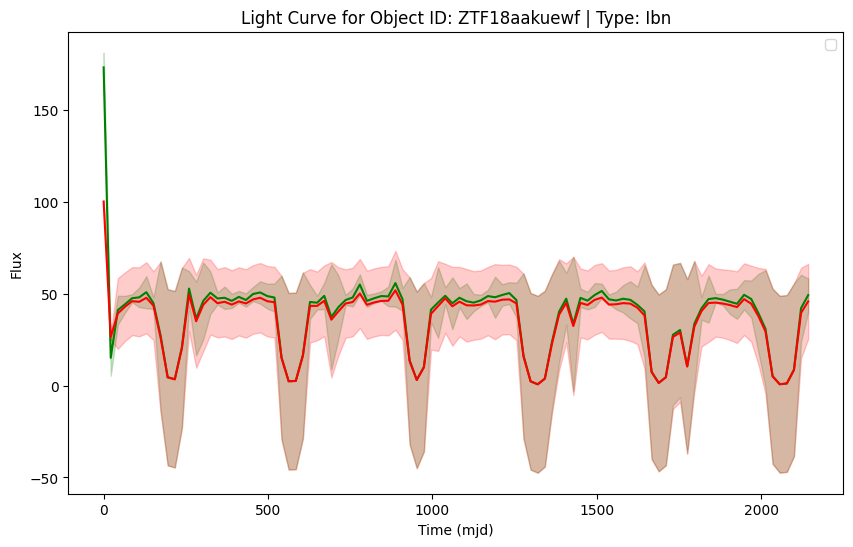

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


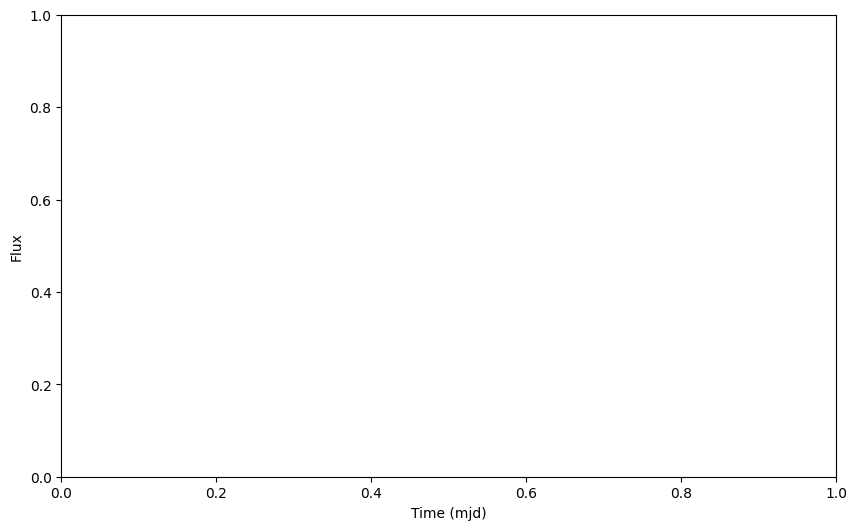

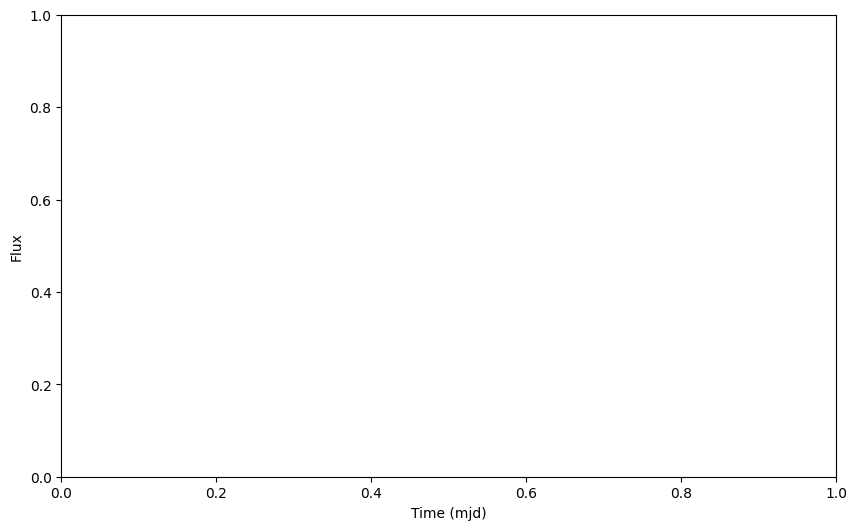

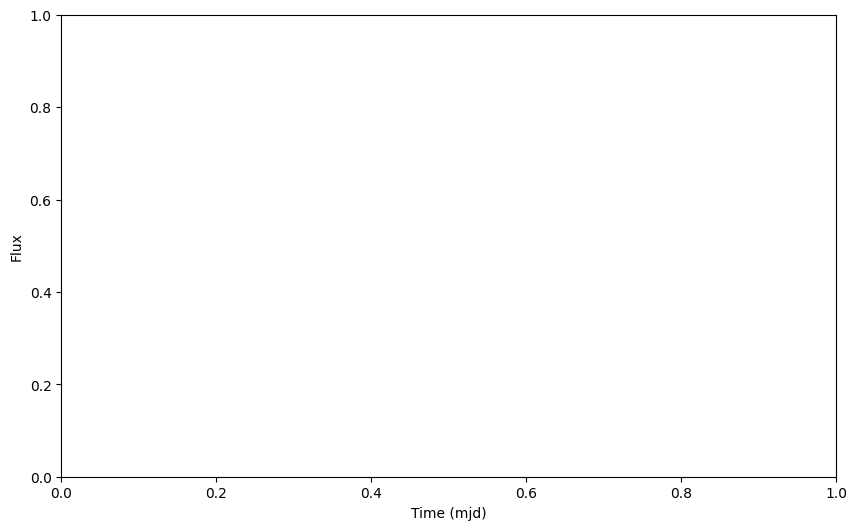

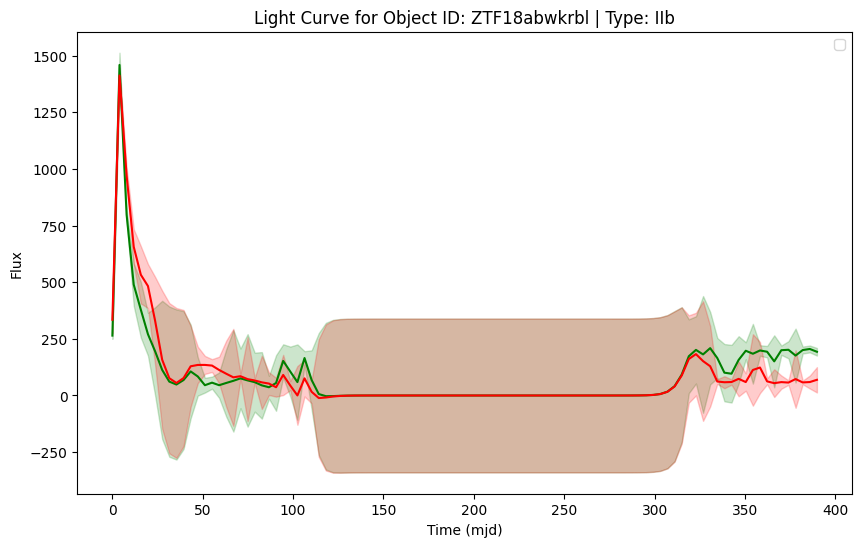

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


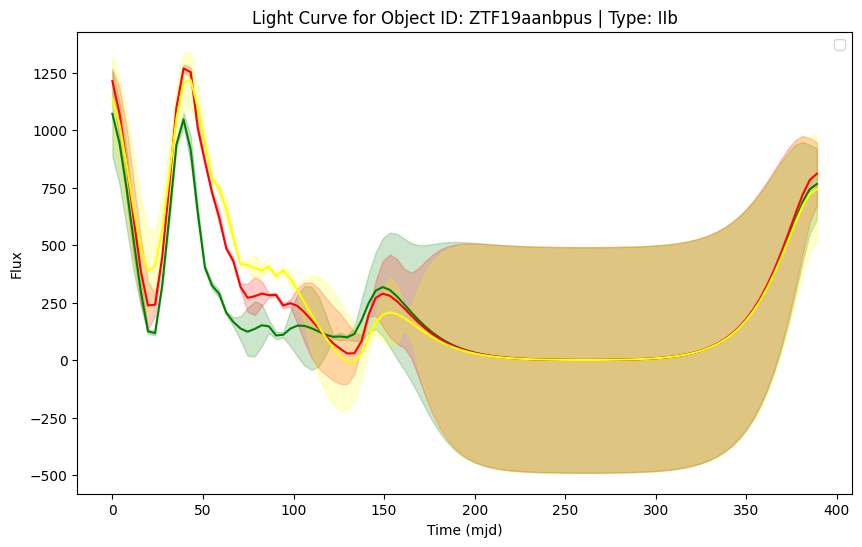

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


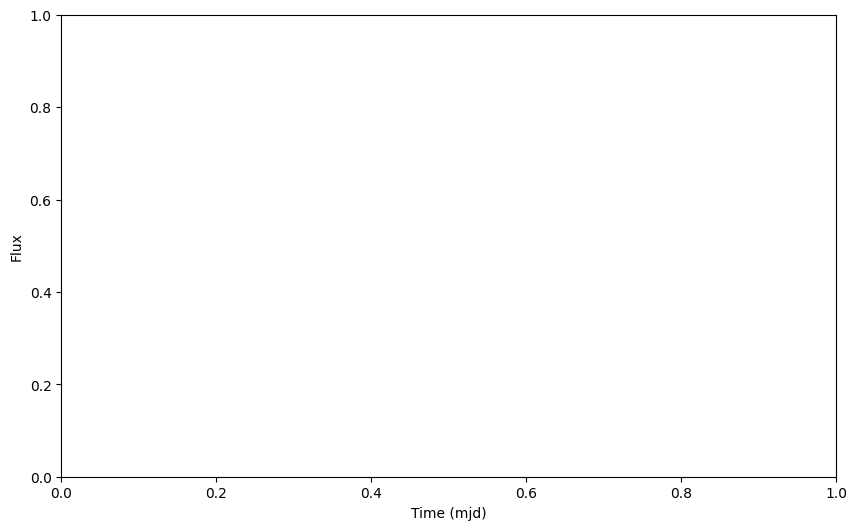

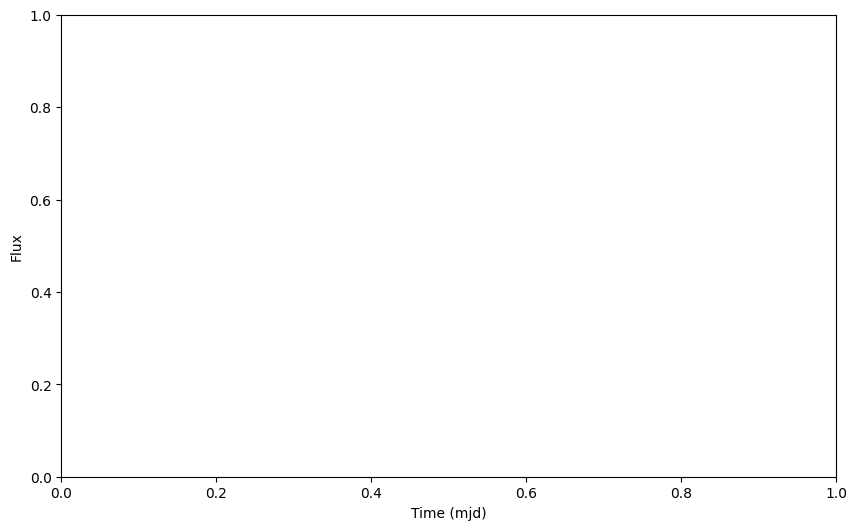

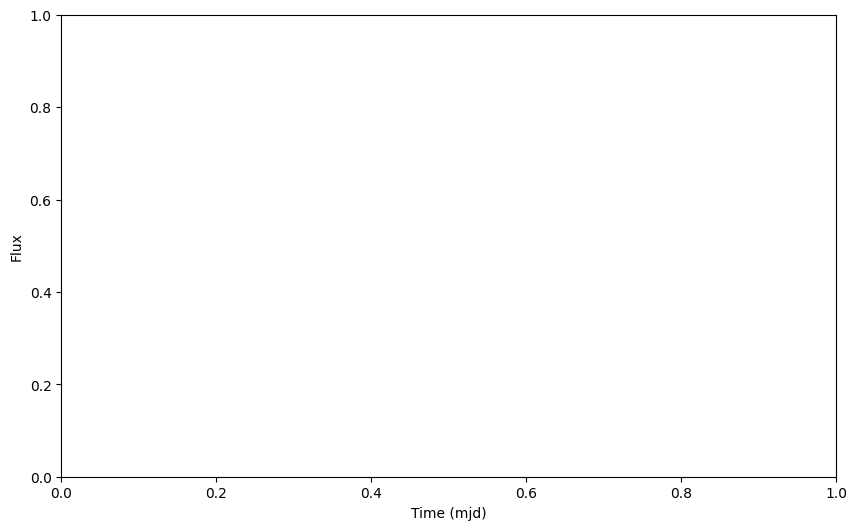

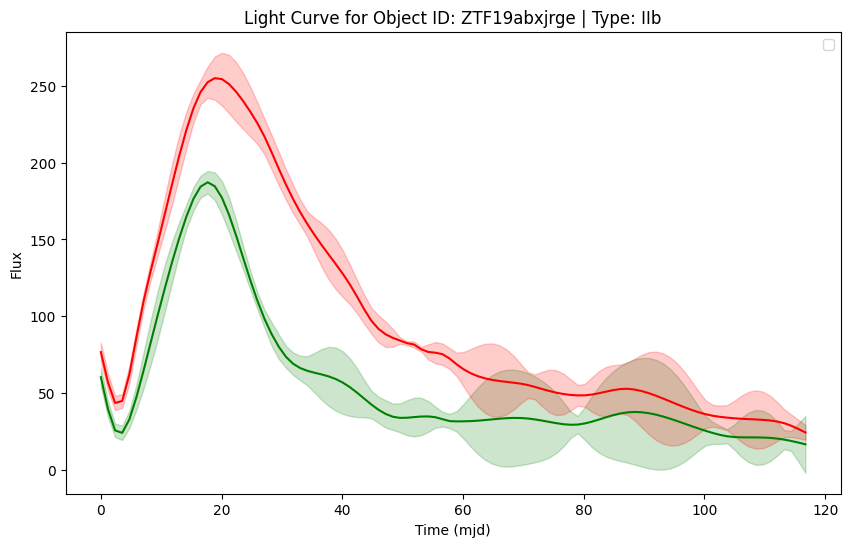

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


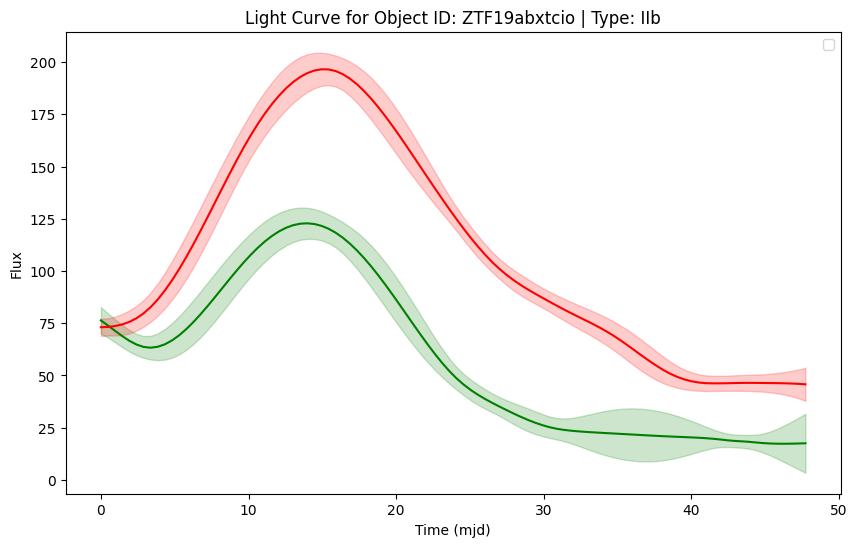

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


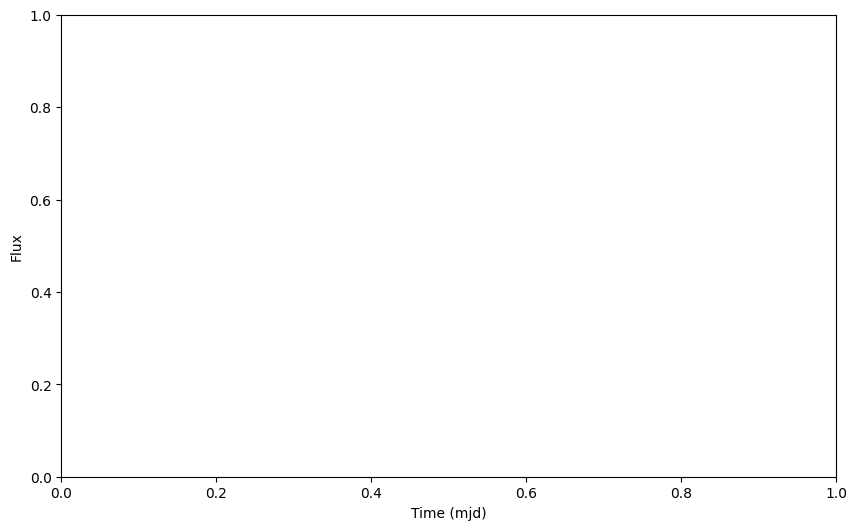

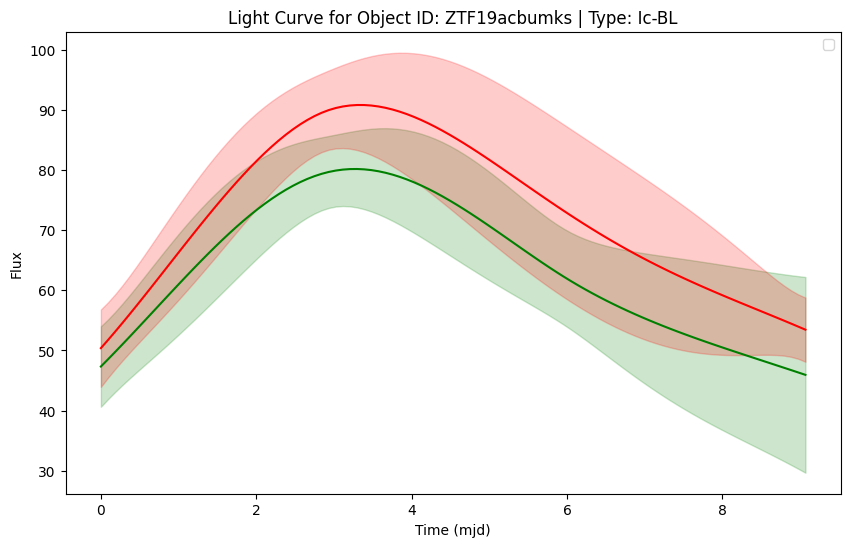

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


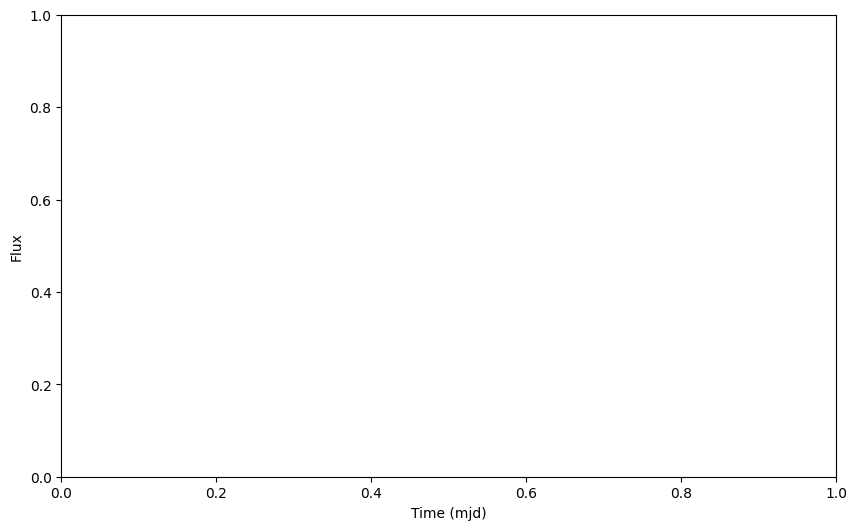

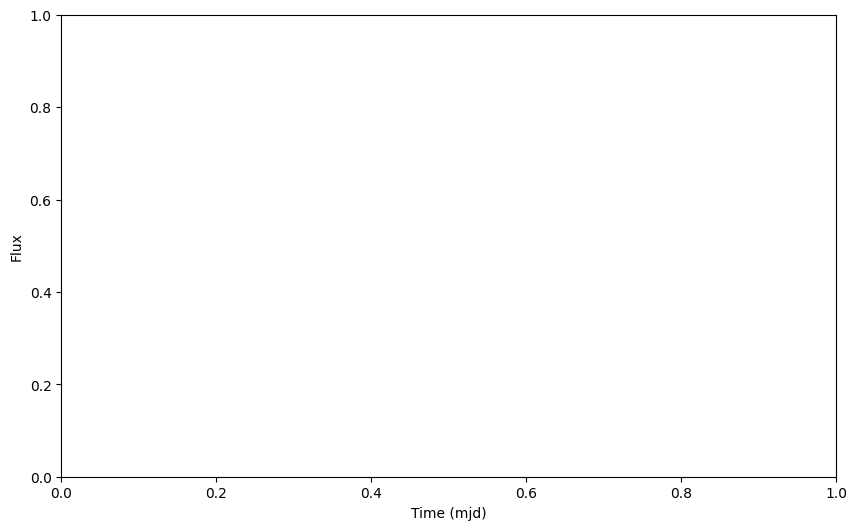

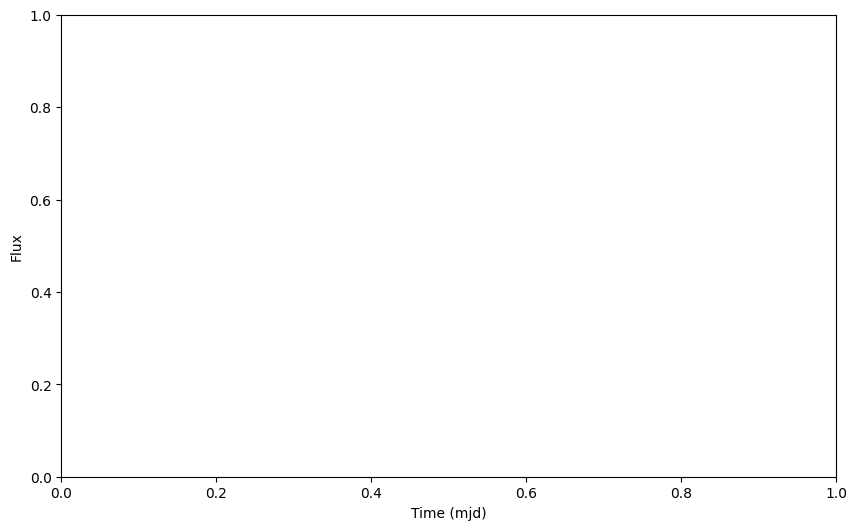

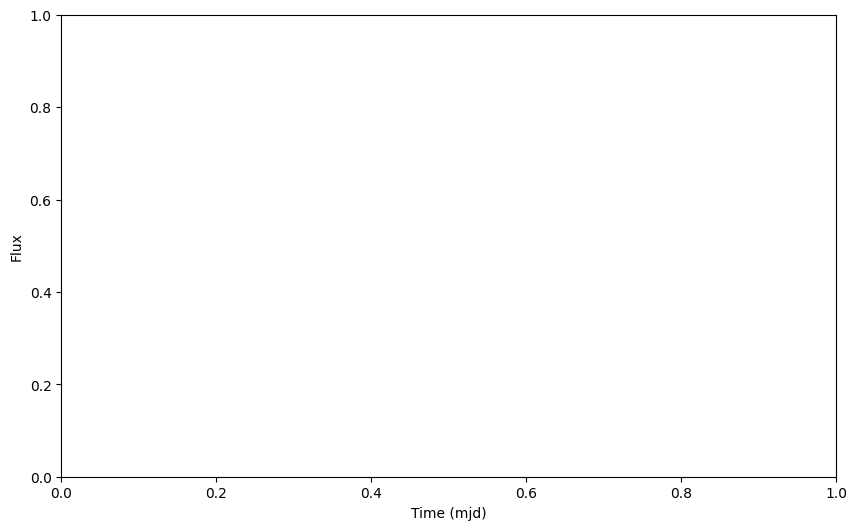

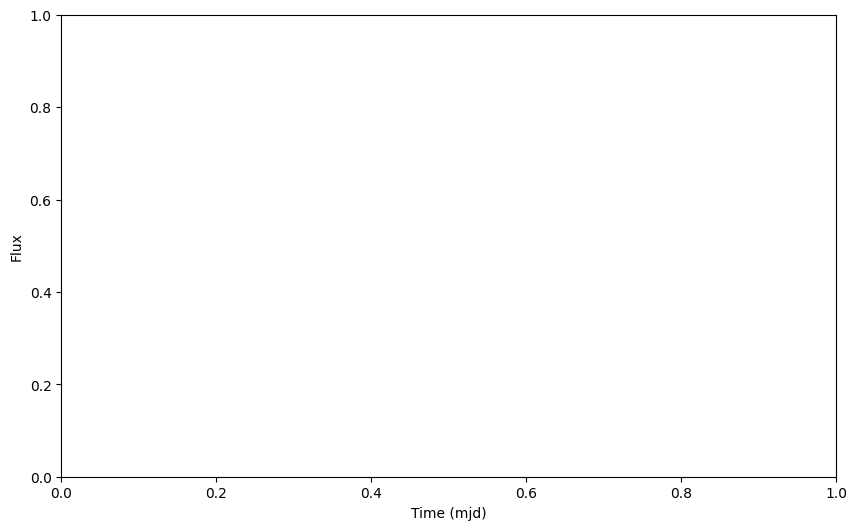

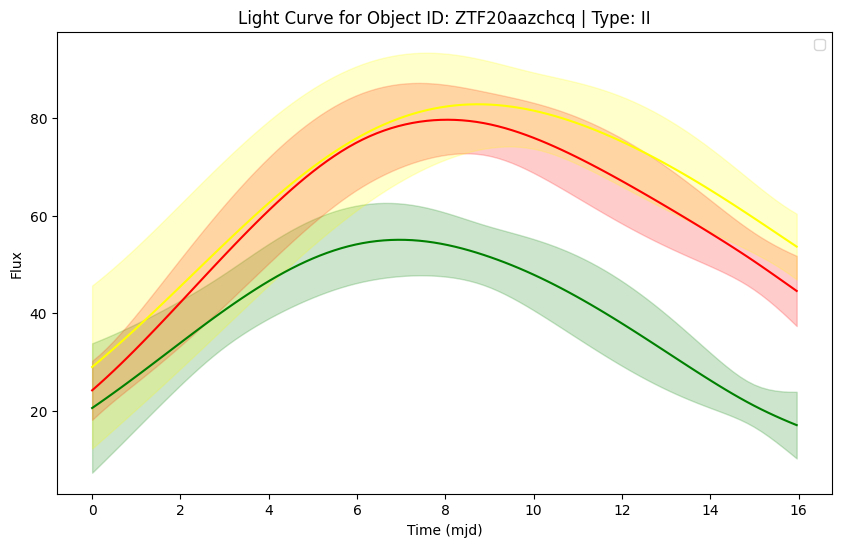

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


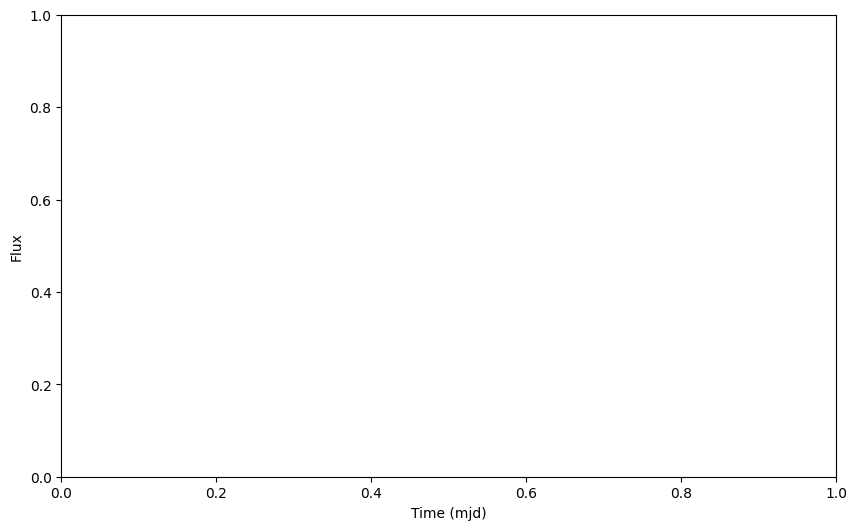

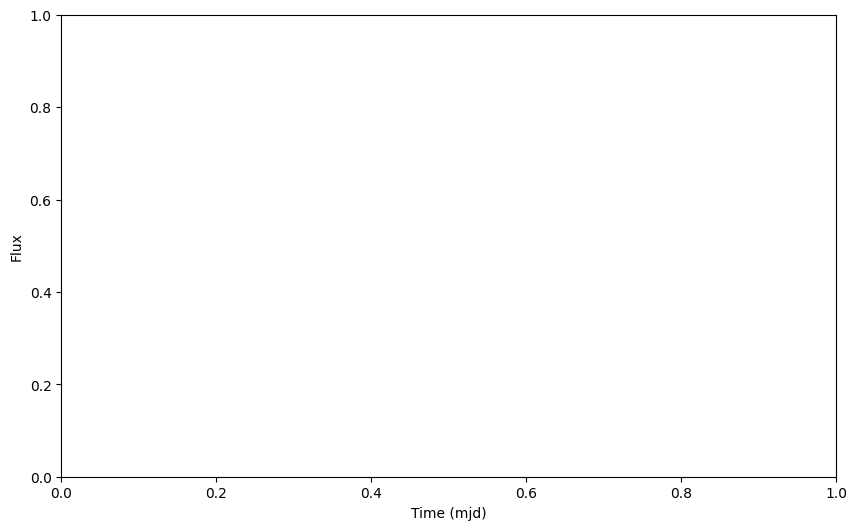

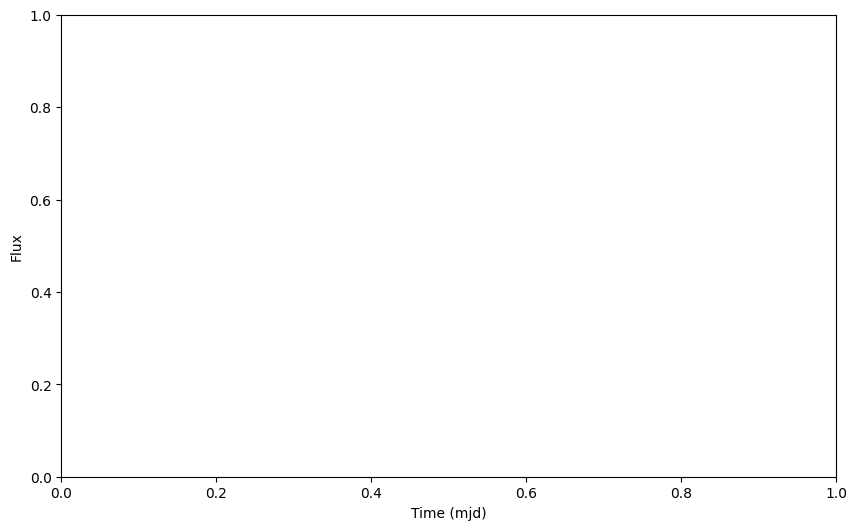

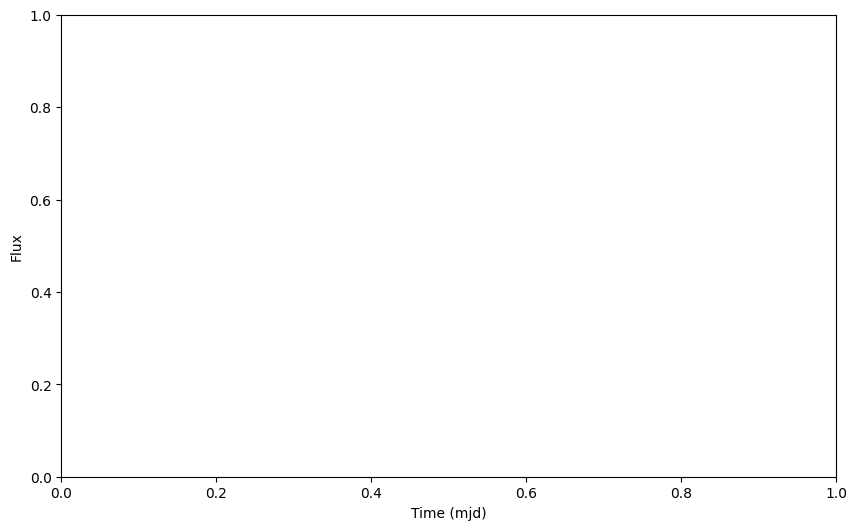

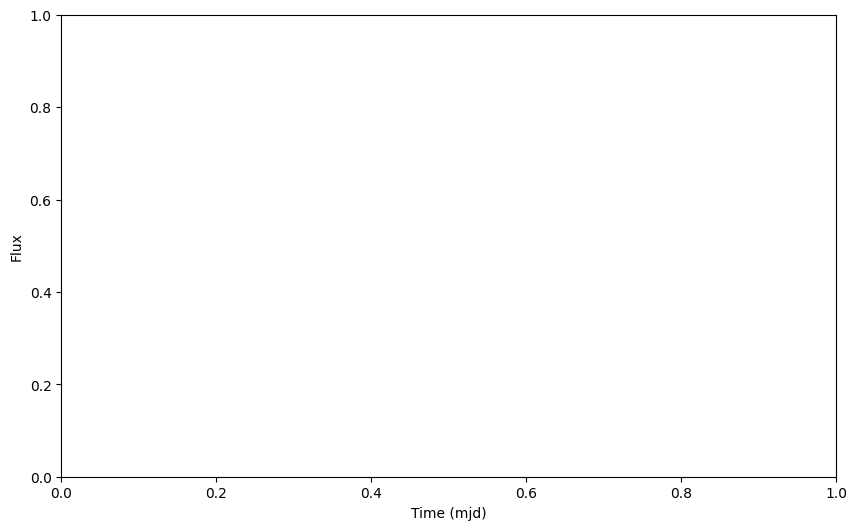

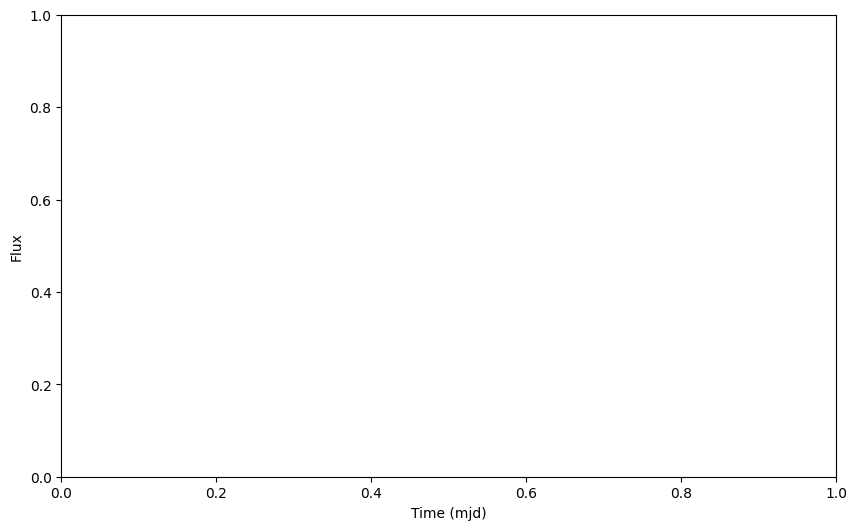

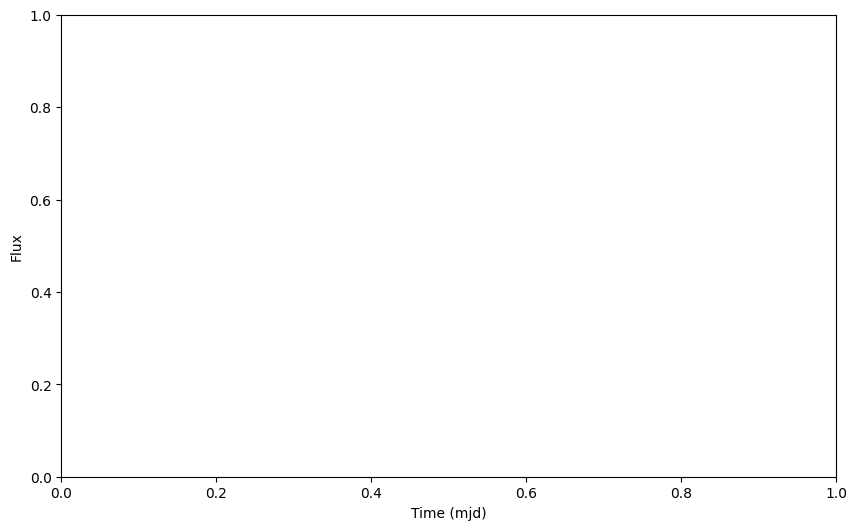

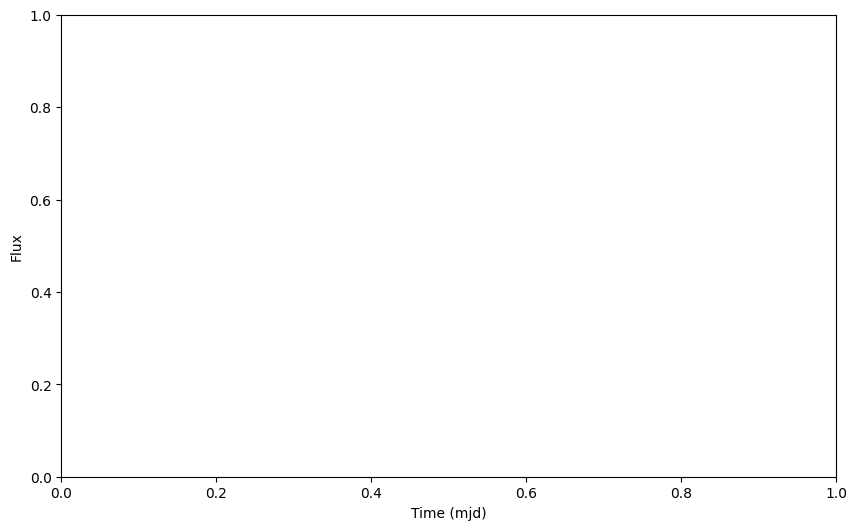

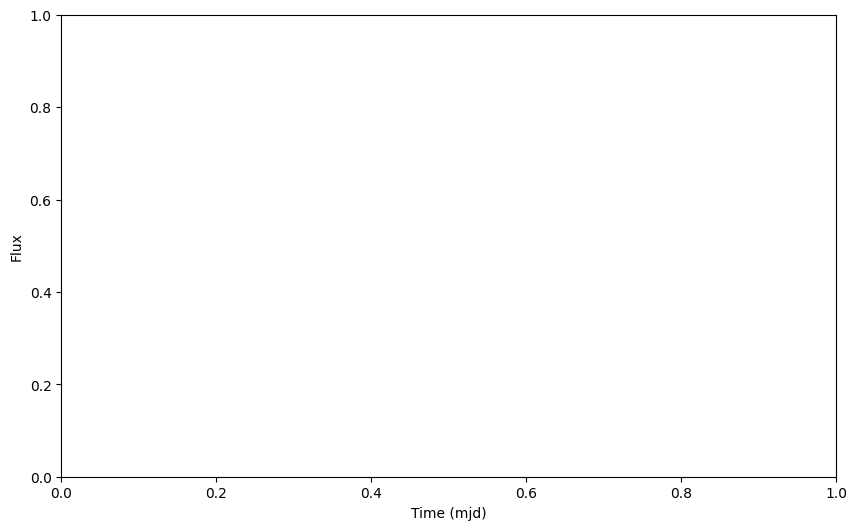

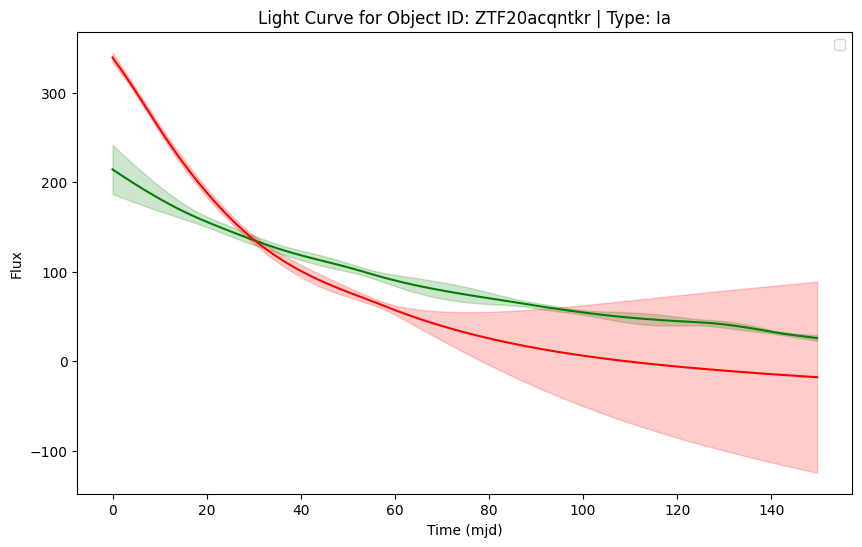

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


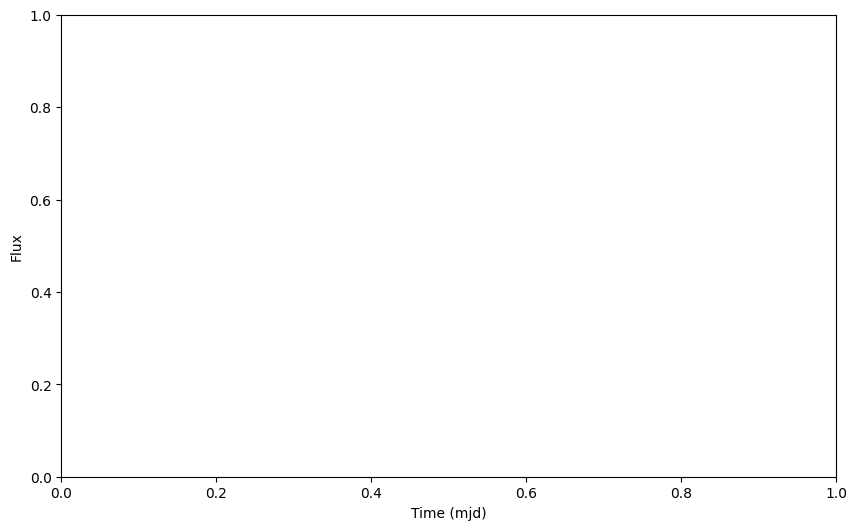

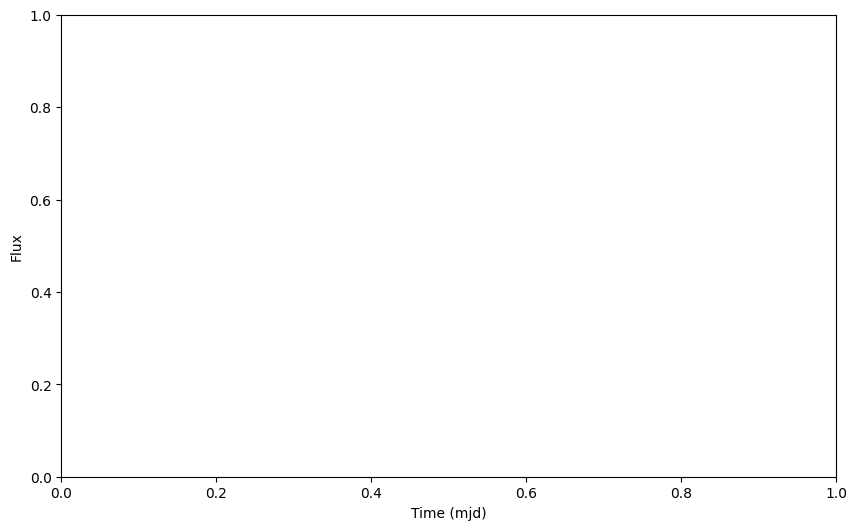

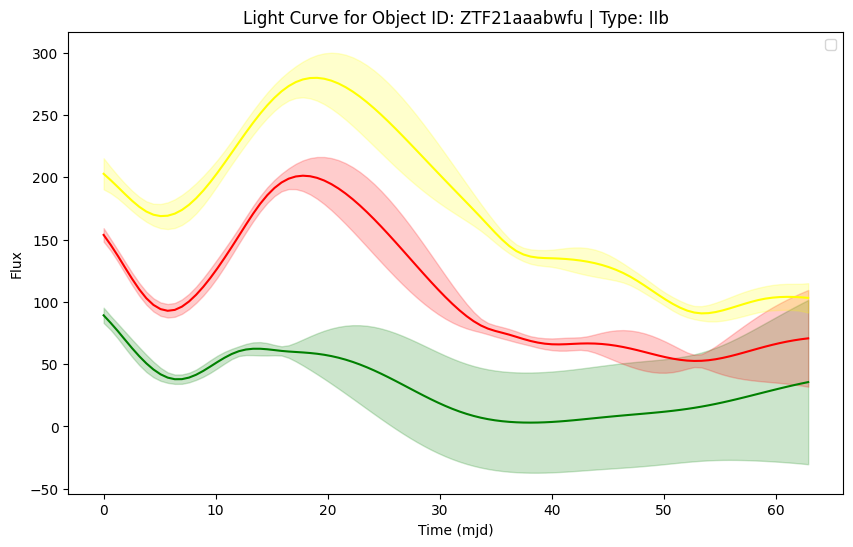

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


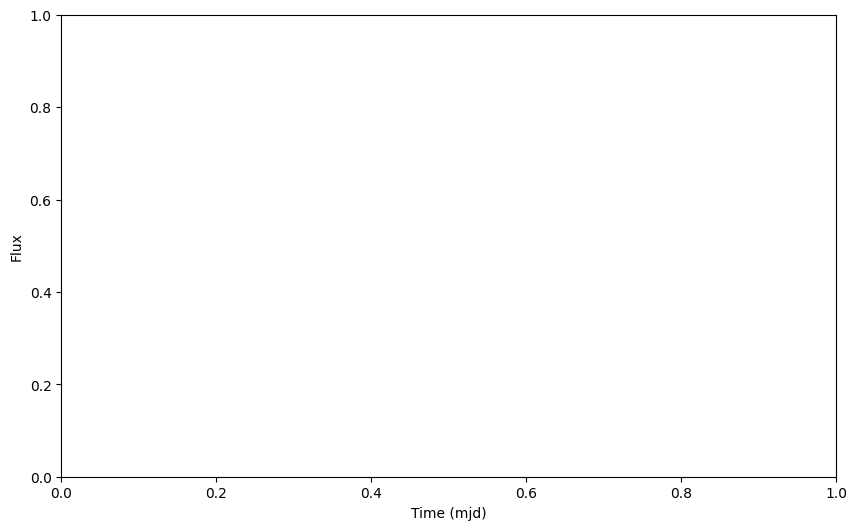

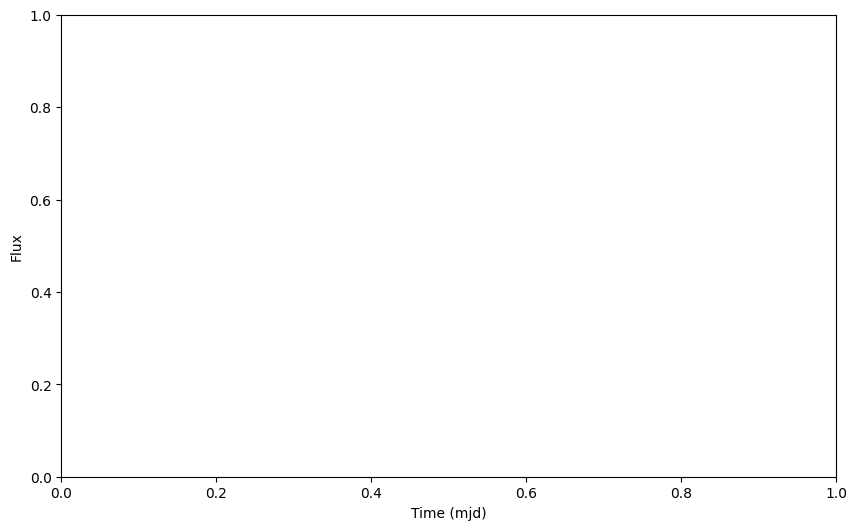

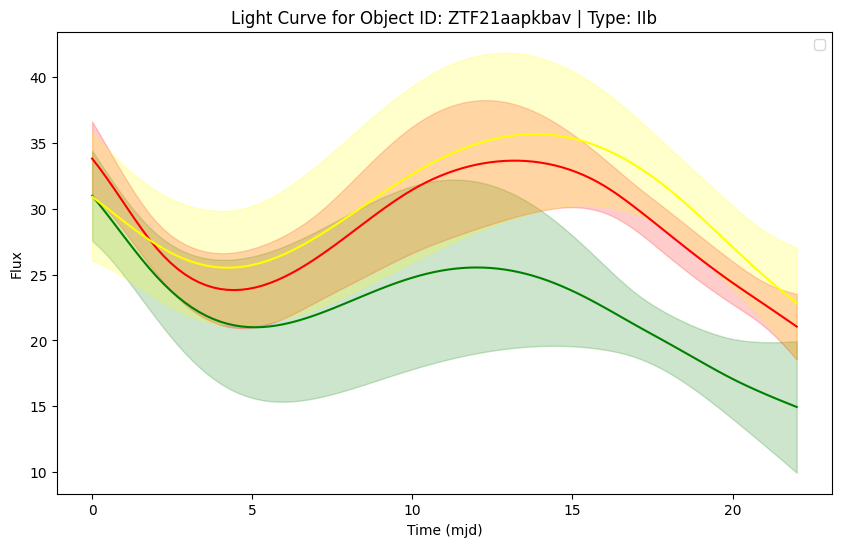

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


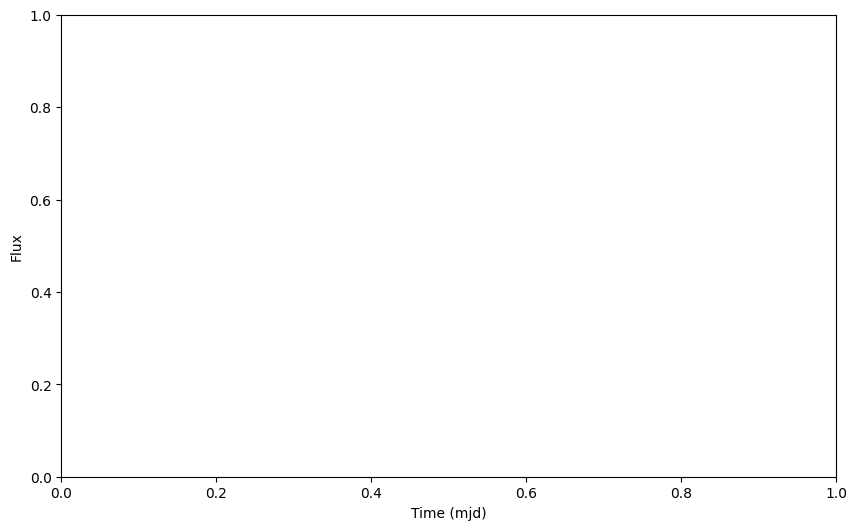

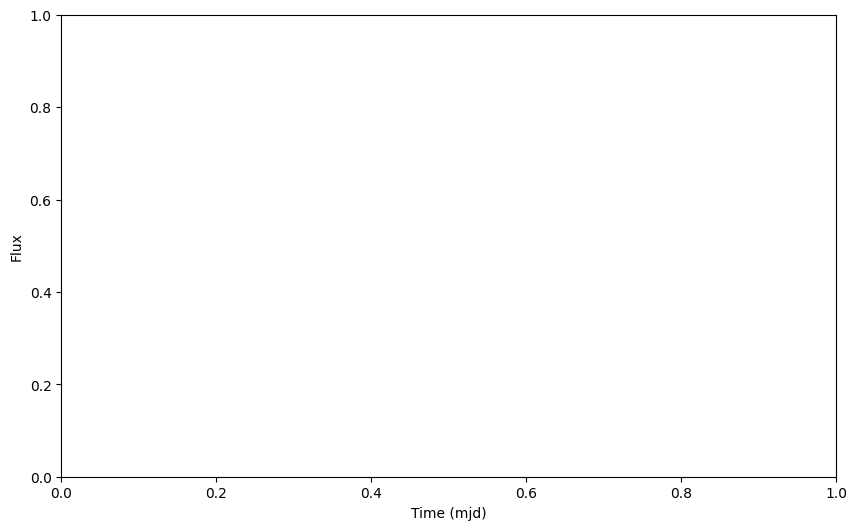

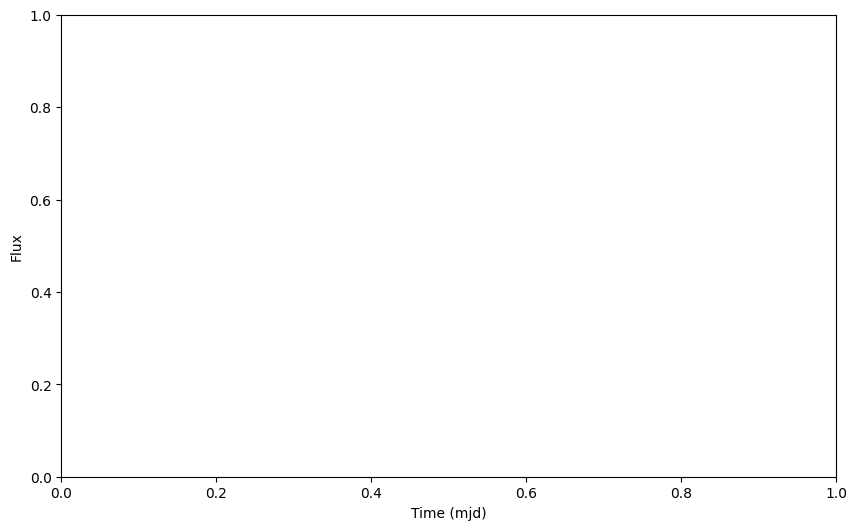

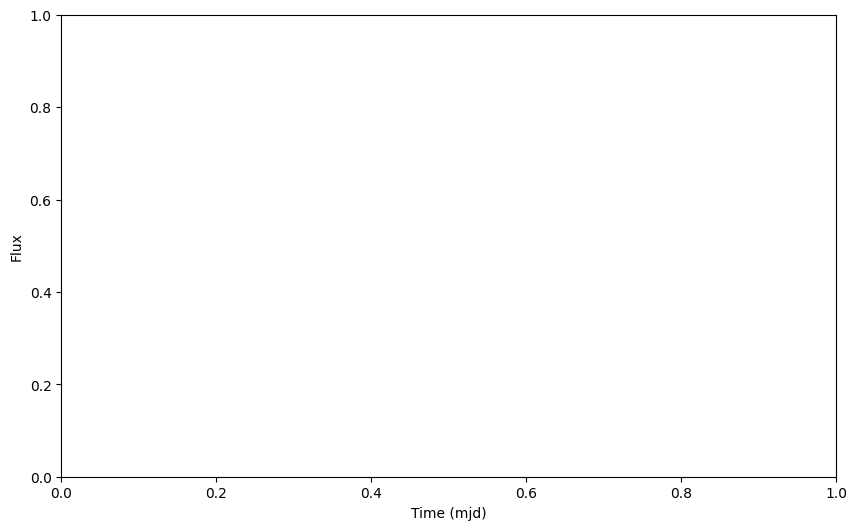

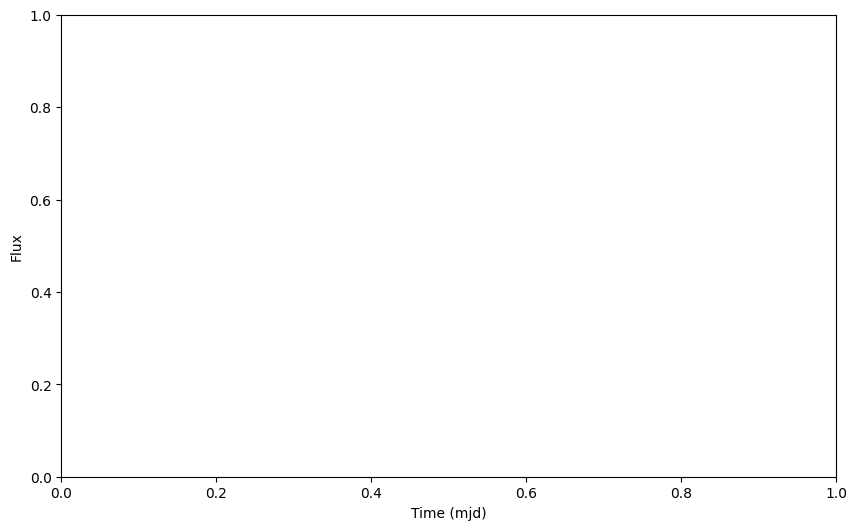

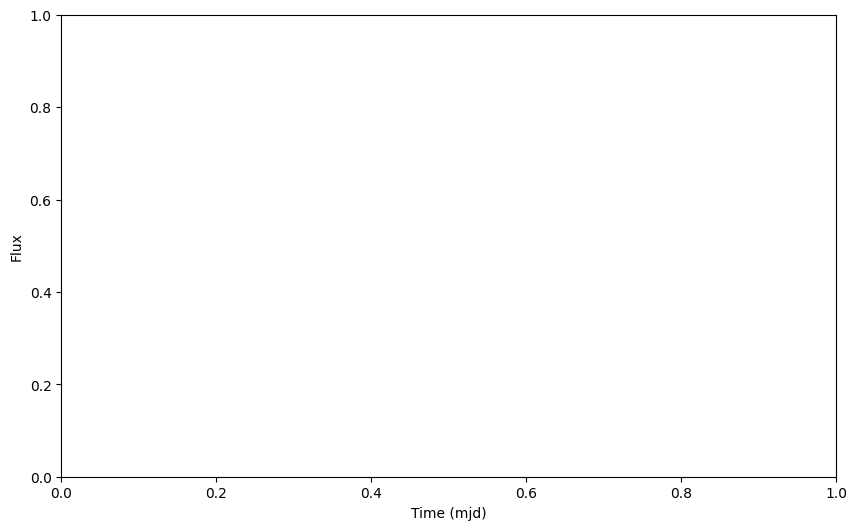

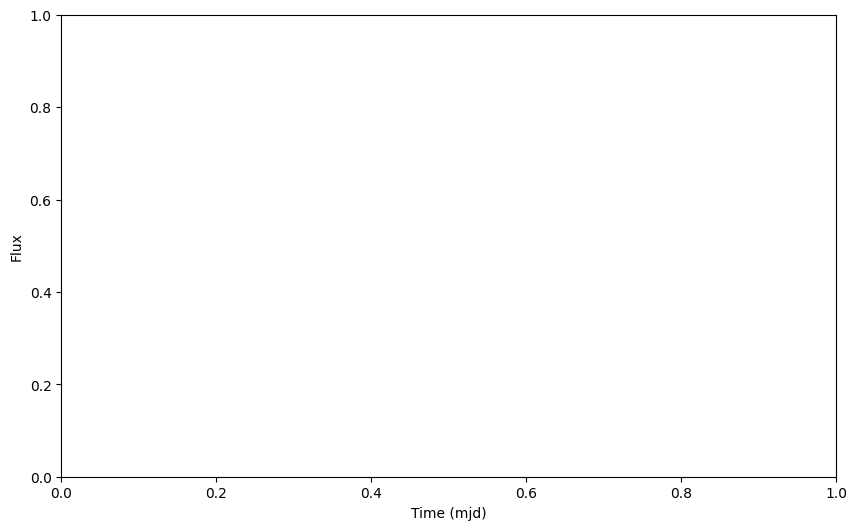

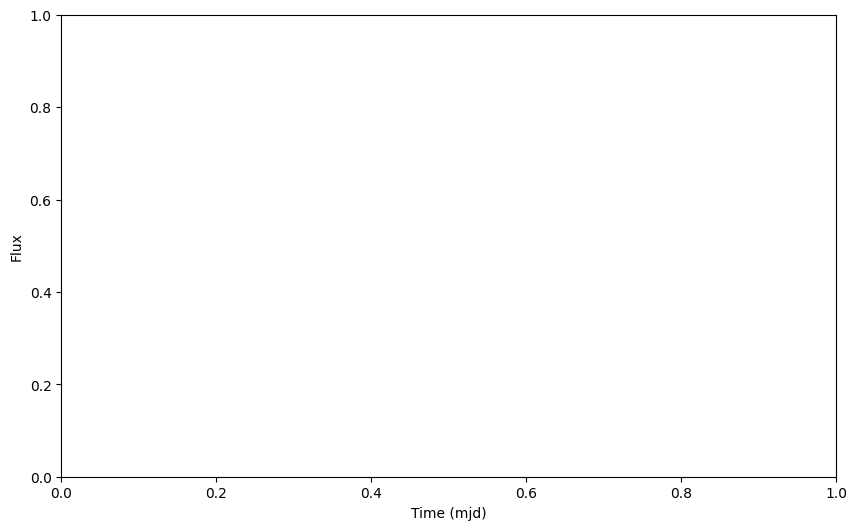

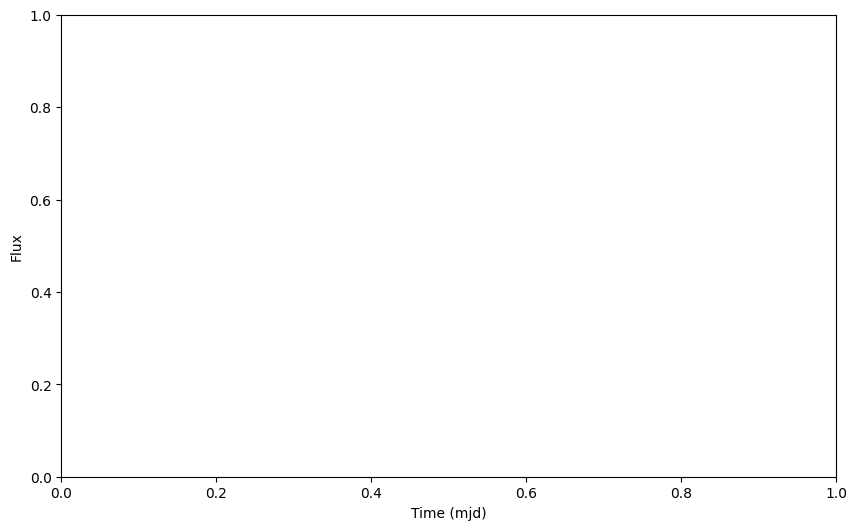

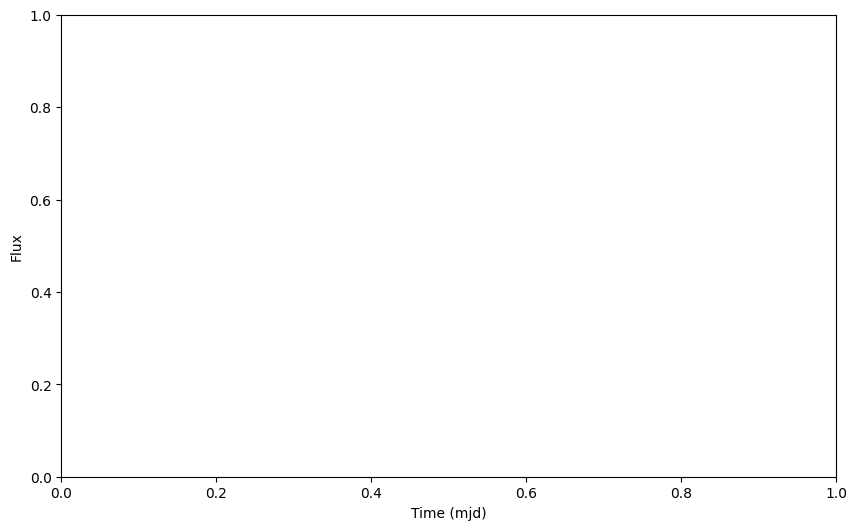

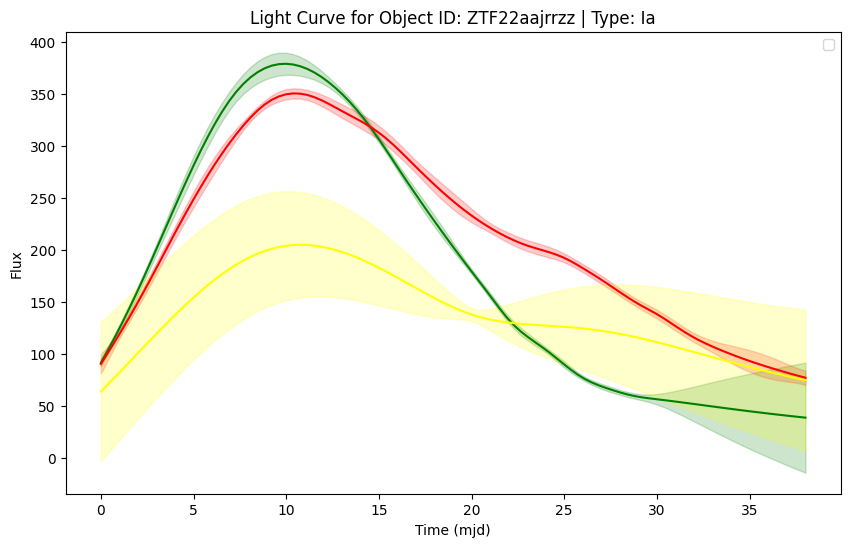

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


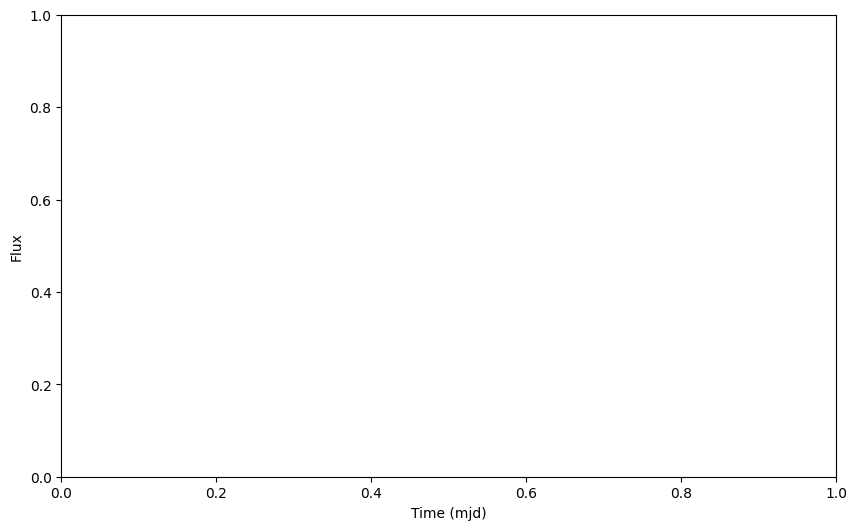

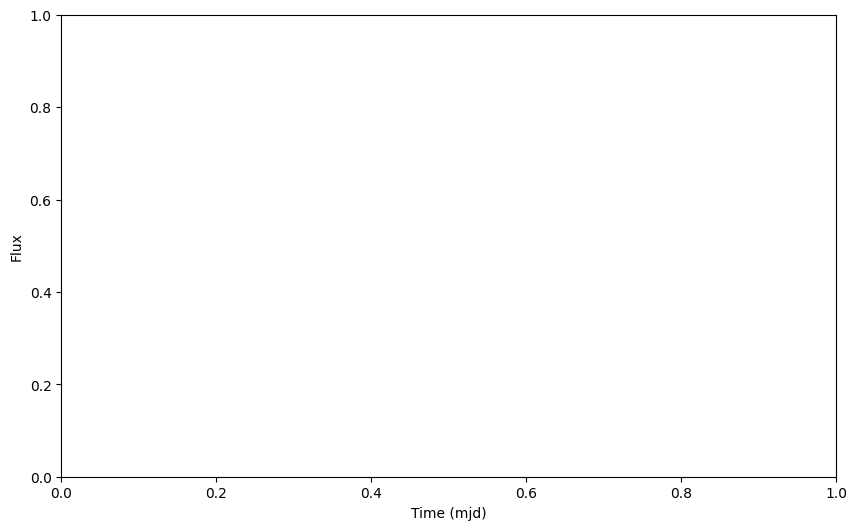

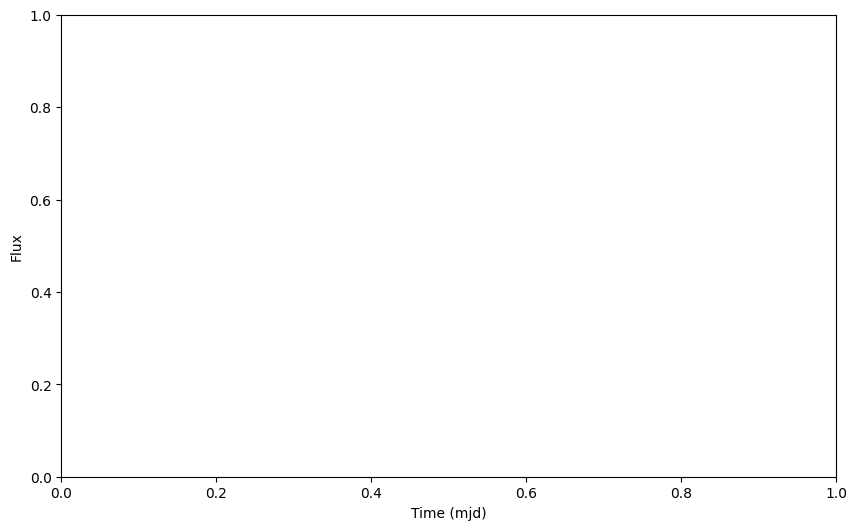

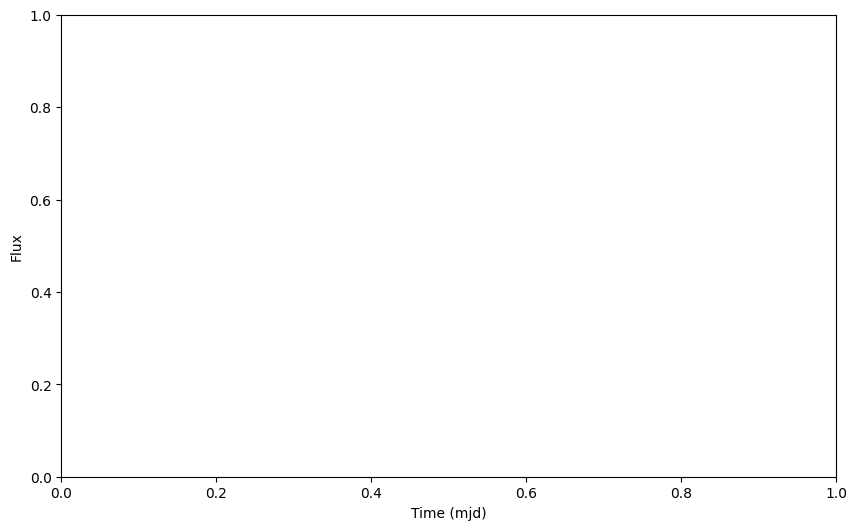

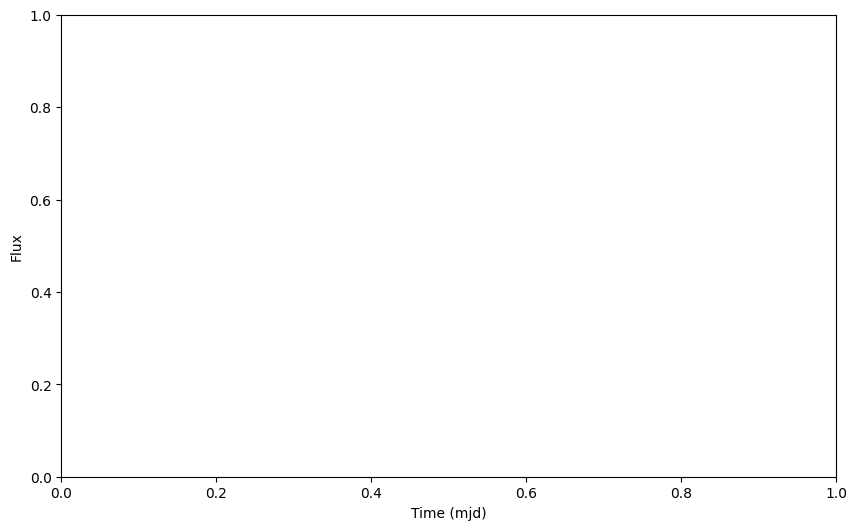

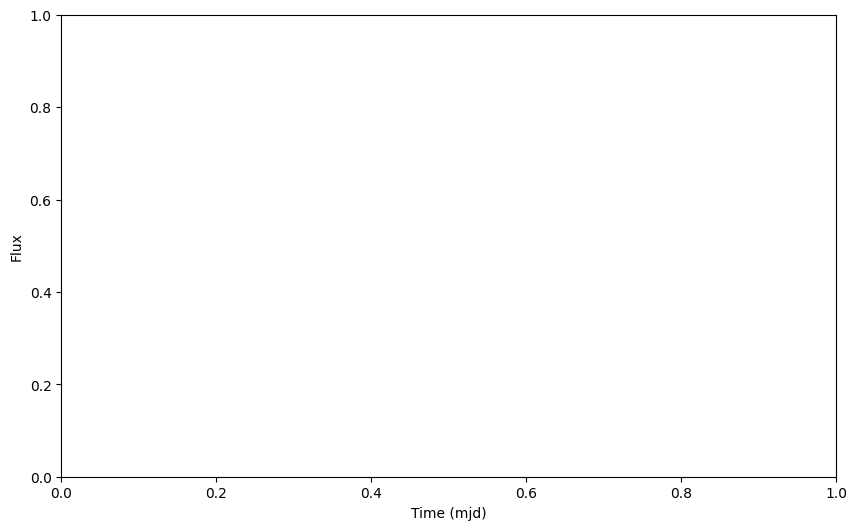

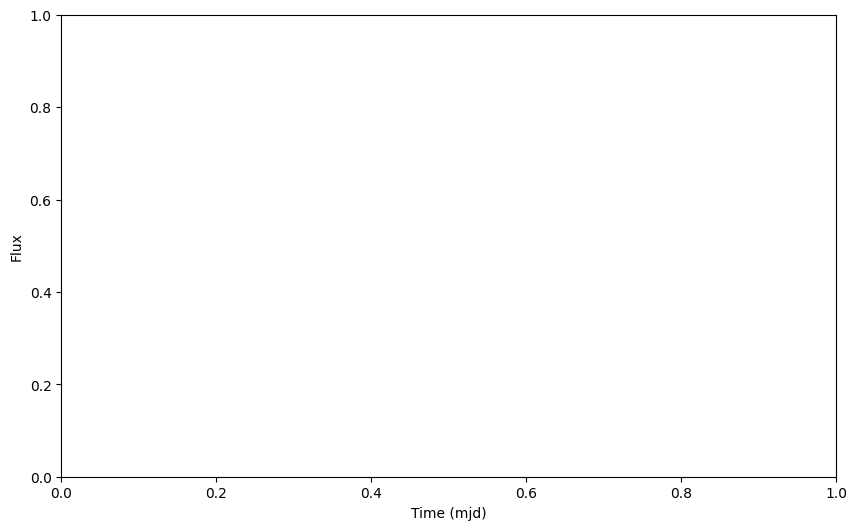

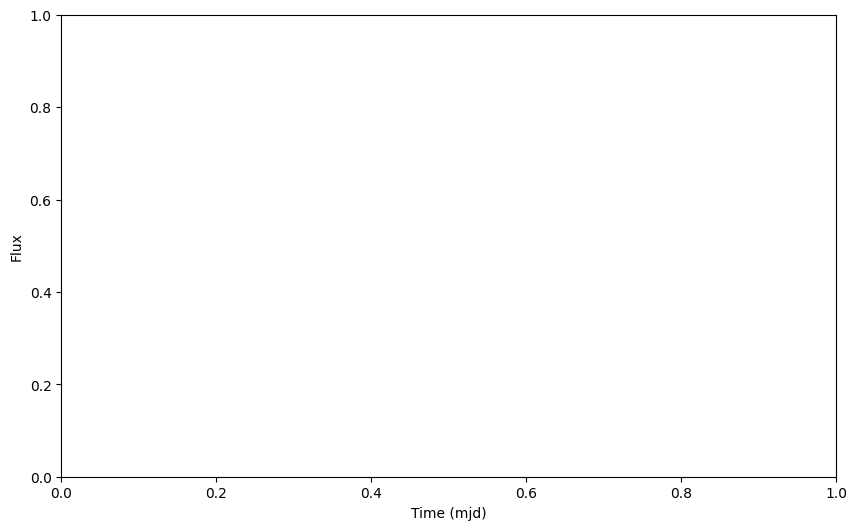

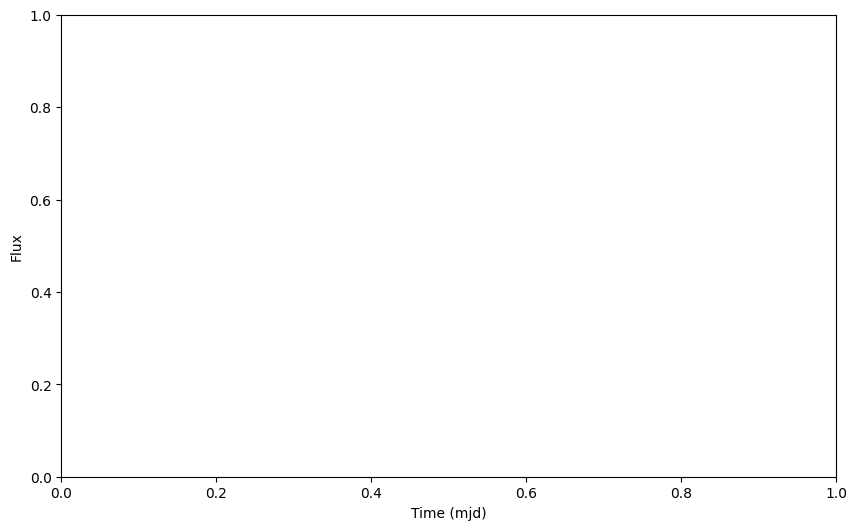

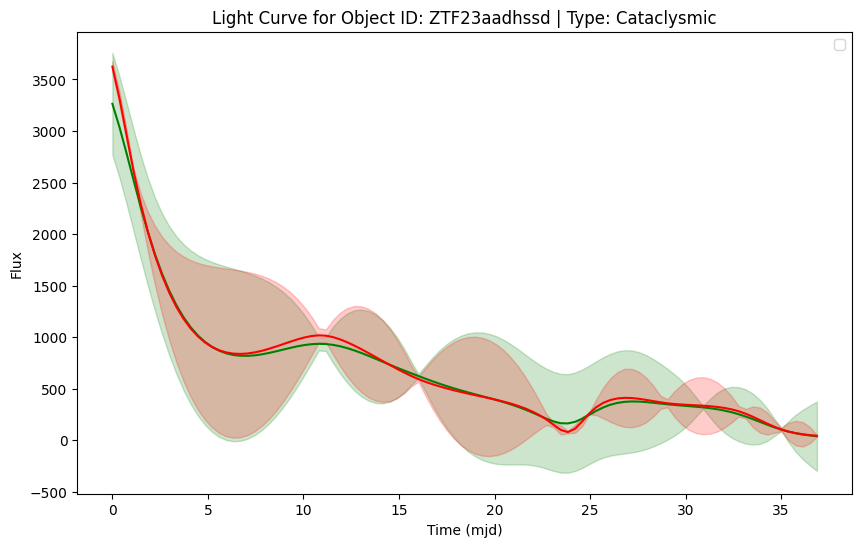

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


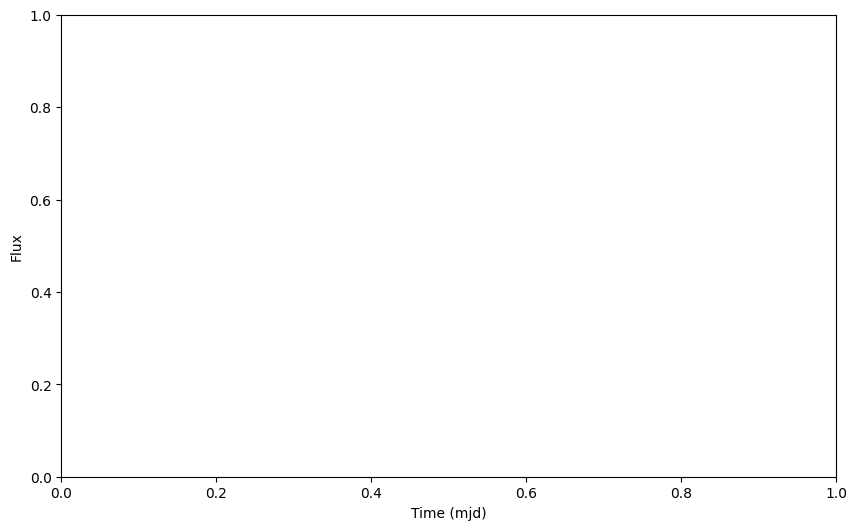

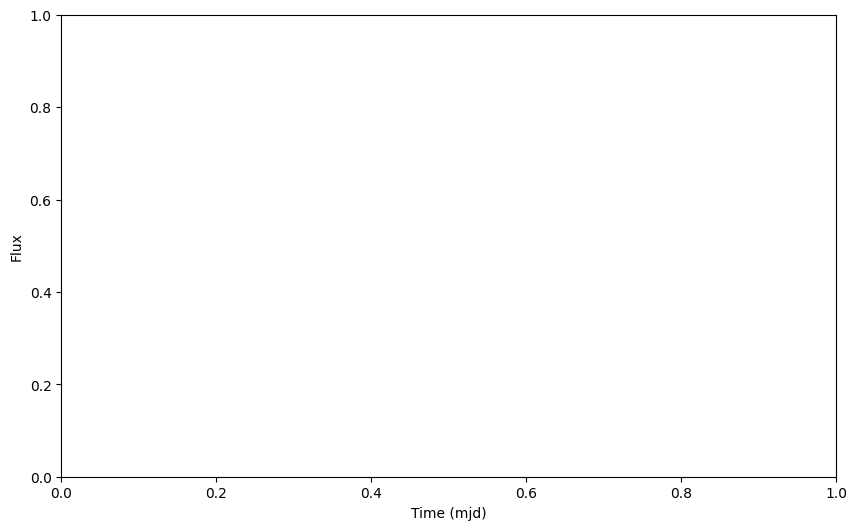

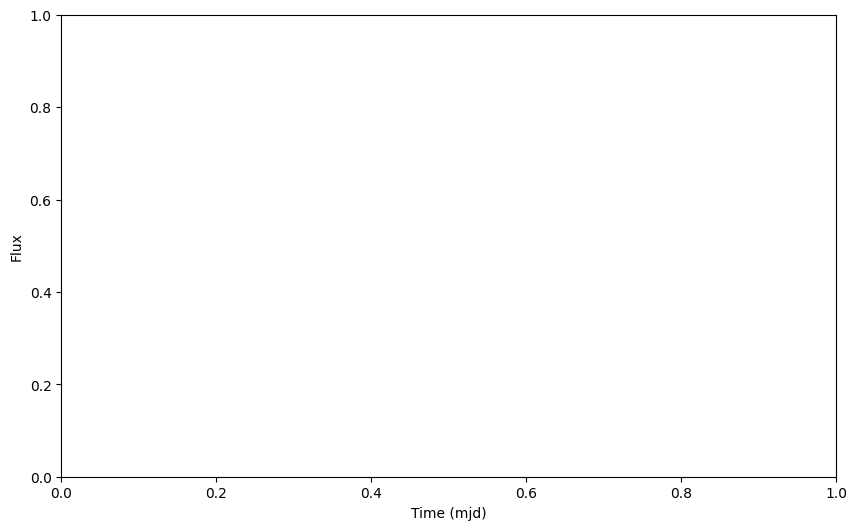

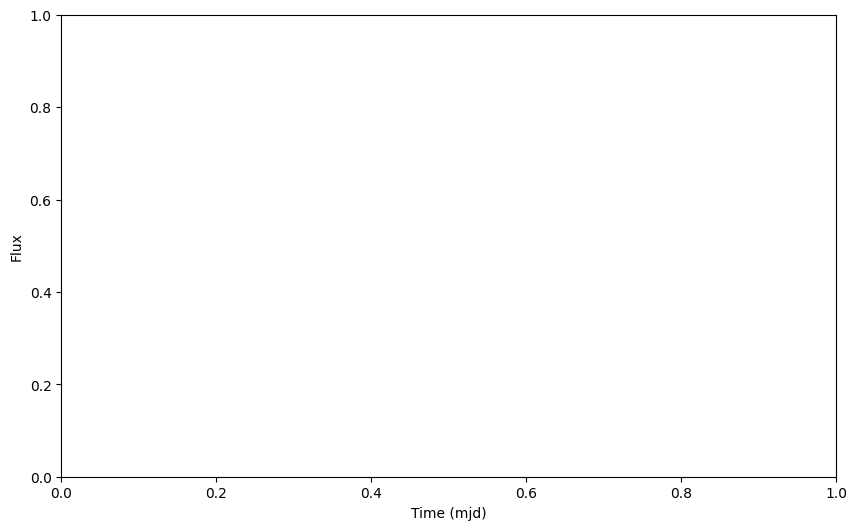

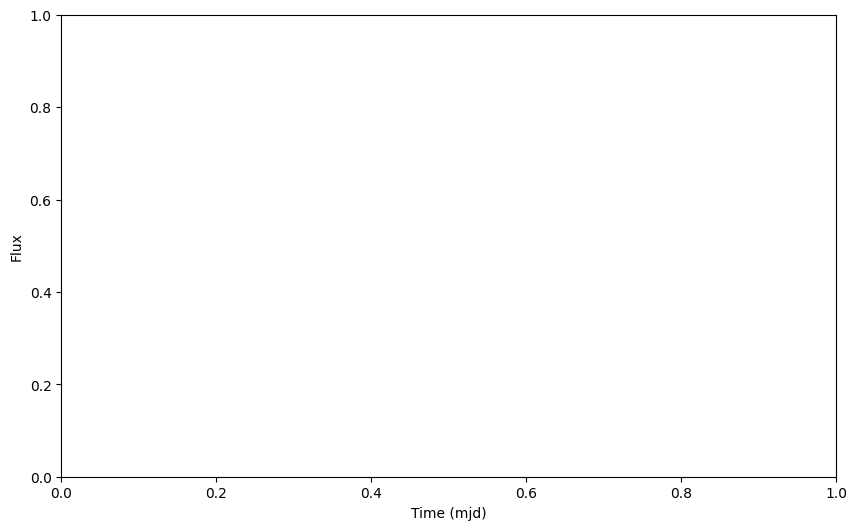

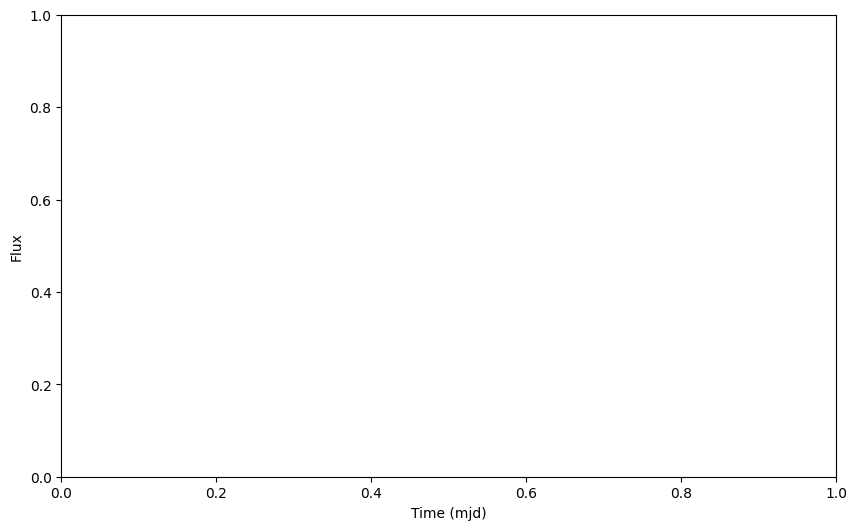

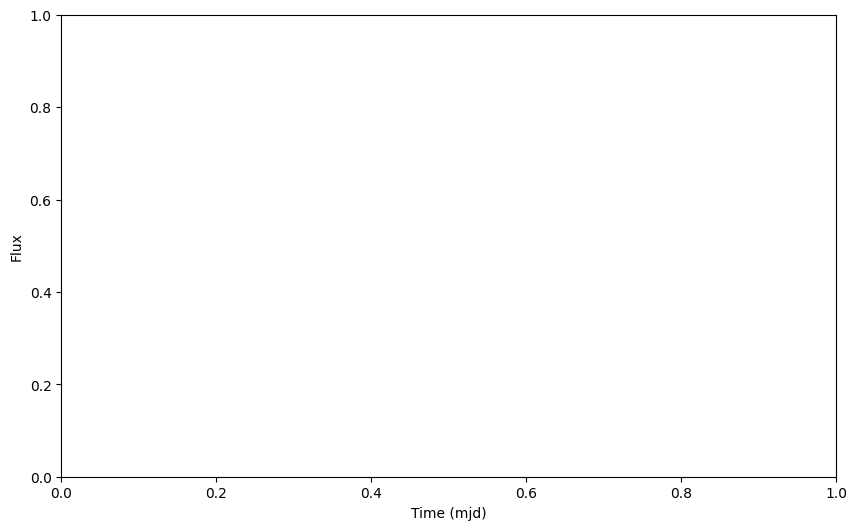

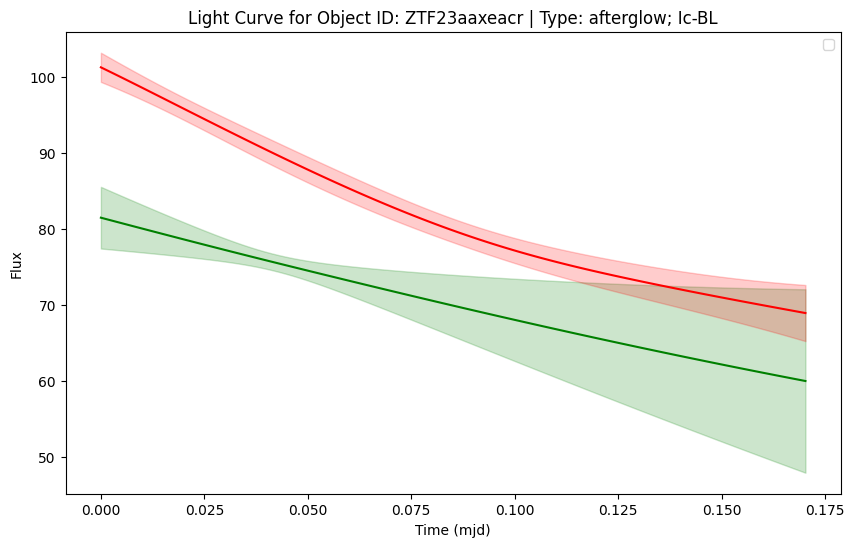

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


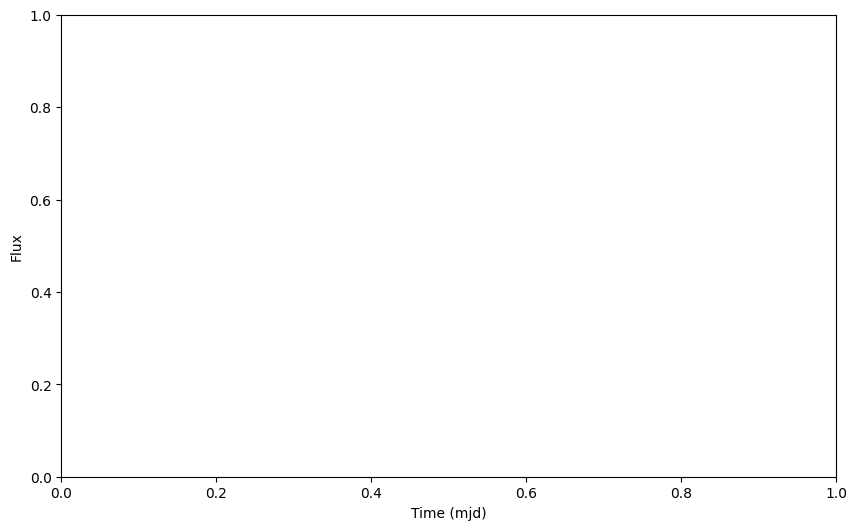

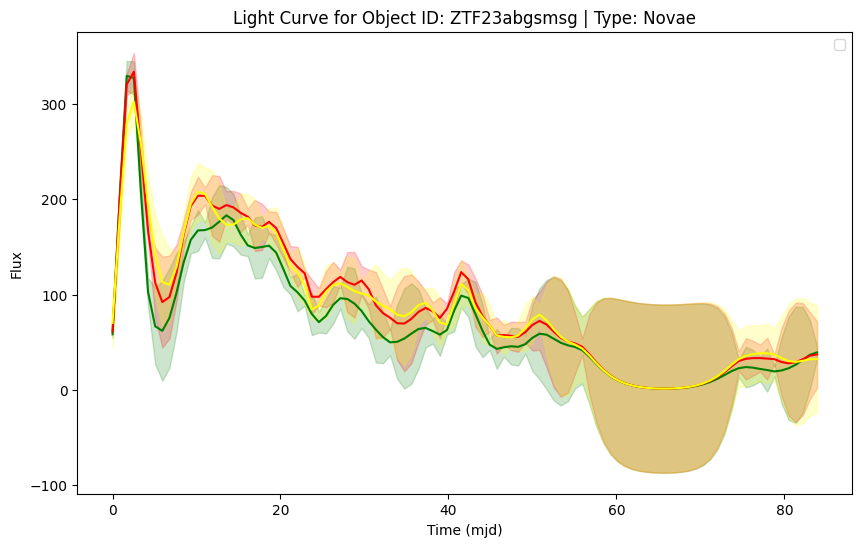

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


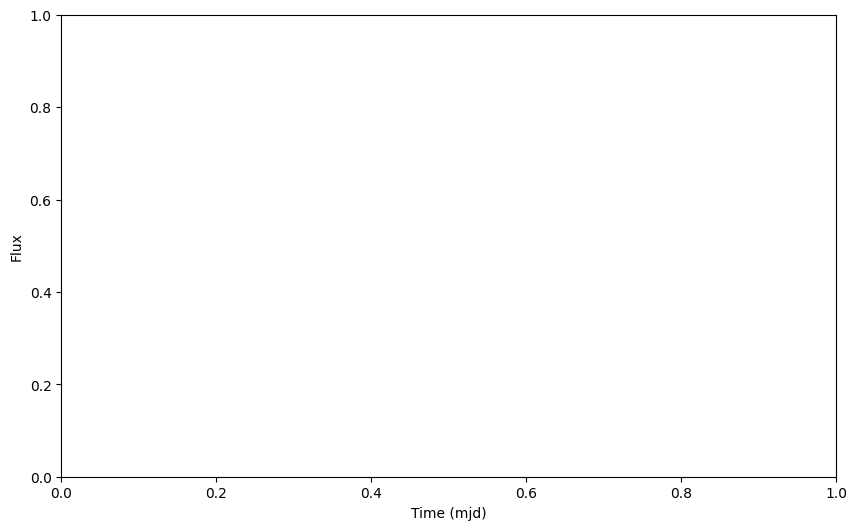

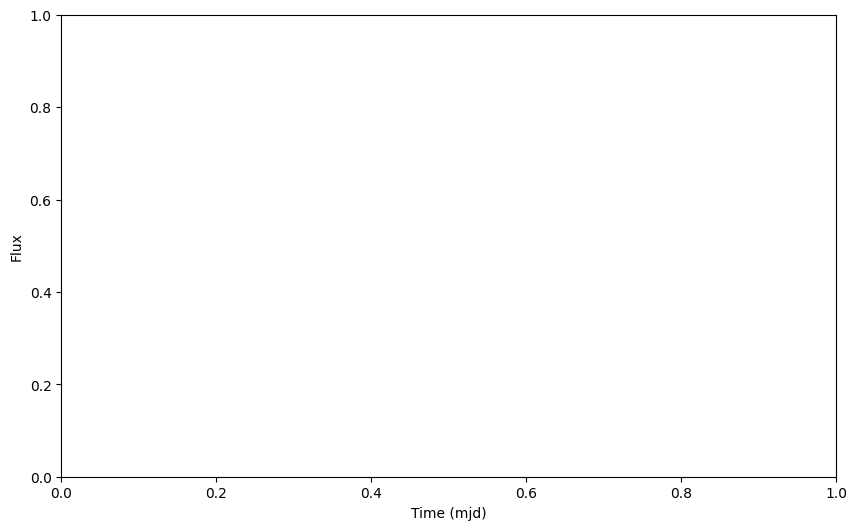

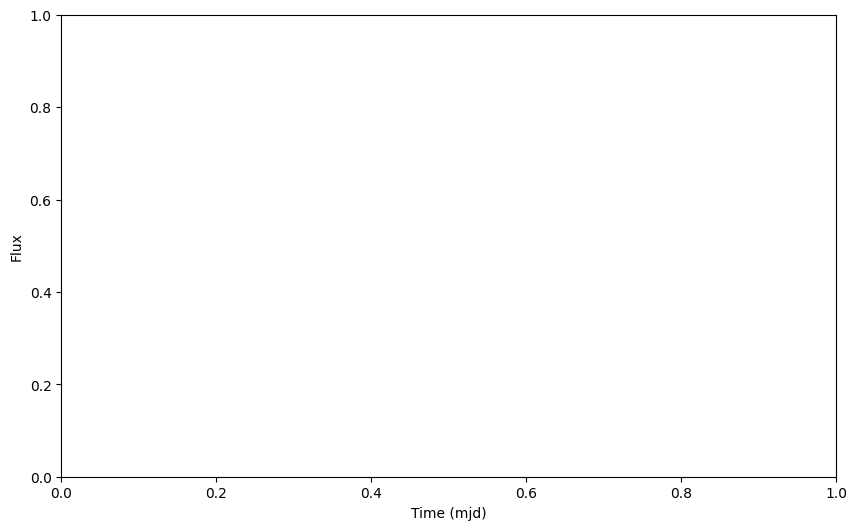

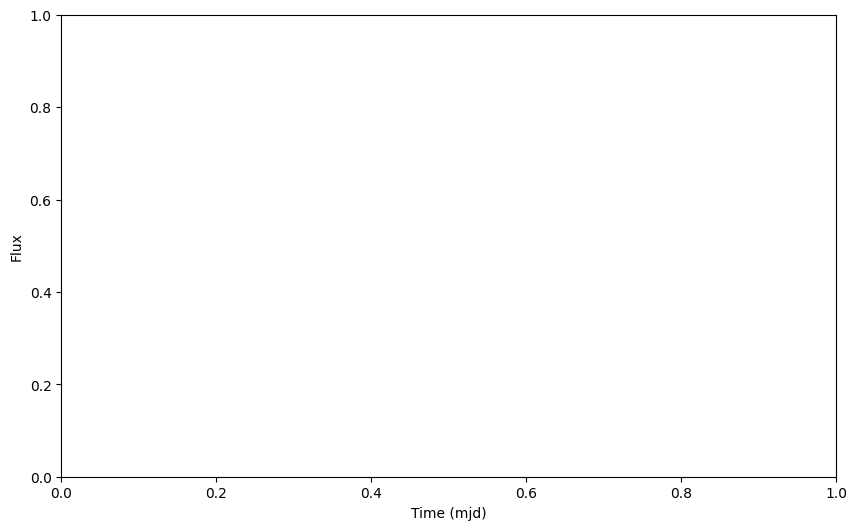

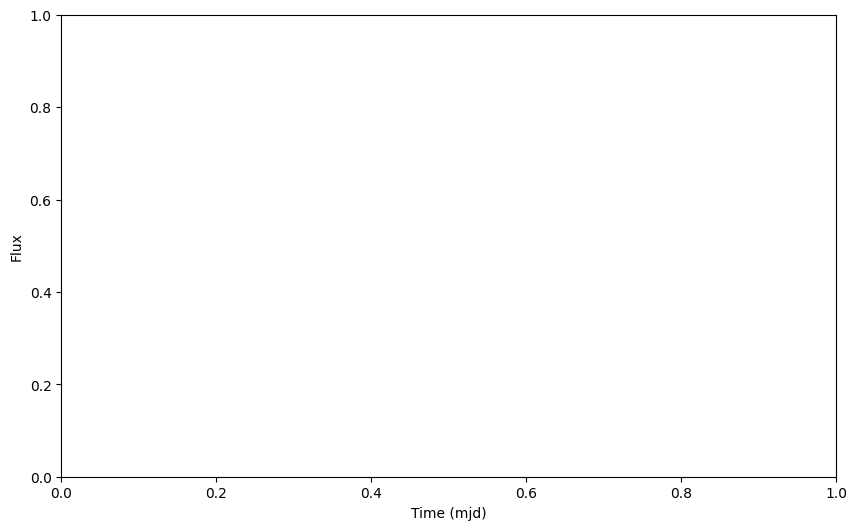

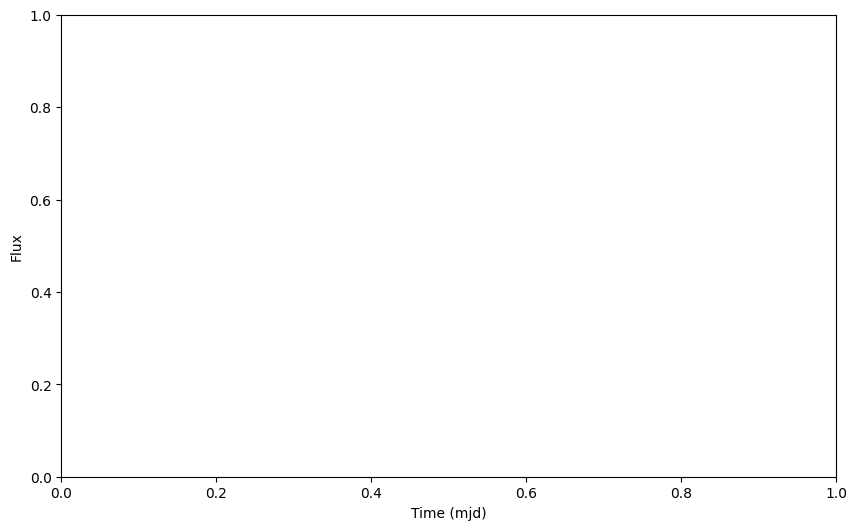

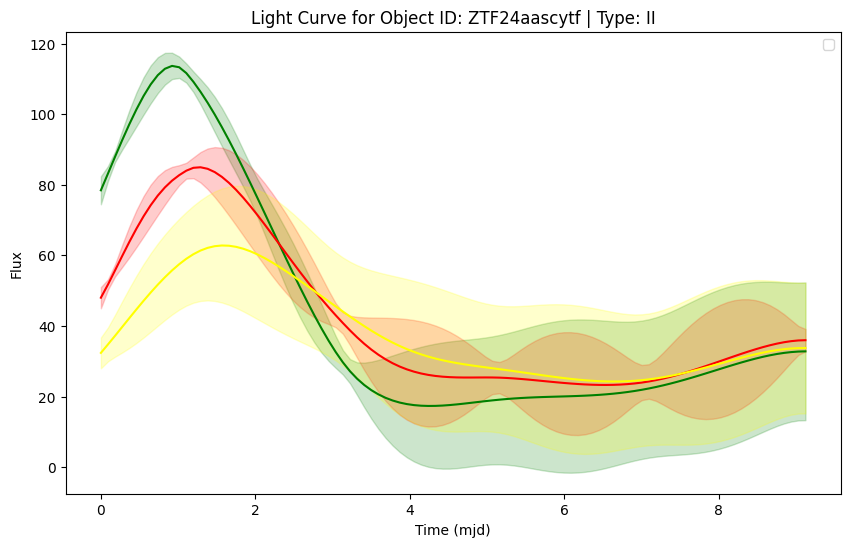

['ZTF18aalrxas', 'ZTF18abffyqp', 'ZTF18abvkmgw', 'ZTF19aapfmki', 'ZTF19aatesgp', 'ZTF19abacxod', 'ZTF19abyjzvd', 'ZTF19accjfgv', 'ZTF20aahfqpm', 'ZTF20aajnksq', 'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20abstsxb', 'ZTF20aburywx', 'ZTF20abwysqy', 'ZTF20abwzqzo', 'ZTF20acgigfo', 'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn', 'ZTF20acozryr', 'ZTF20actqnhg', 'ZTF21aaabrpu', 'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aaqzrat', 'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn', 'ZTF21abhywxv', 'ZTF21aciosfu', 'ZTF22aaajecp', 'ZTF22aabjpxh', 'ZTF22aahgvlx', 'ZTF22aaibbvy', 'ZTF22aayluxo', 'ZTF22aazmooy', 'ZTF22abfjnpj', 'ZTF22abfxmpc', 'ZTF22abijszk', 'ZTF22abmsaxp', 'ZTF22abntkbk', 'ZTF22abuzpzz', 'ZTF22acaruqr', 'ZTF23aaemgsd', 'ZTF23aaeozpp', 'ZTF23aaikakr', 'ZTF23aaimsja', 'ZTF23aajadma', 'ZTF23aaoohpy', 'ZTF23aarlxdf', 'ZTF23aaxzvrr', 'ZTF23abjwgre', 'ZTF23abnpdod', 'ZTF23abobwsd', 'ZTF23absafzo', 'ZTF23absbqun', 'ZTF23abtycgb']


In [108]:
obj_ids = total_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = test_results[test_results['obj_id'] == obj]
    try:
        plot_gp(one_df)
    except:
        broken_obj_ids.append(obj)

print(broken_obj_ids)

In [109]:
print(broken_obj_ids)

['ZTF18aalrxas', 'ZTF18abffyqp', 'ZTF18abvkmgw', 'ZTF19aapfmki', 'ZTF19aatesgp', 'ZTF19abacxod', 'ZTF19abyjzvd', 'ZTF19accjfgv', 'ZTF20aahfqpm', 'ZTF20aajnksq', 'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20abstsxb', 'ZTF20aburywx', 'ZTF20abwysqy', 'ZTF20abwzqzo', 'ZTF20acgigfo', 'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn', 'ZTF20acozryr', 'ZTF20actqnhg', 'ZTF21aaabrpu', 'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aaqzrat', 'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn', 'ZTF21abhywxv', 'ZTF21aciosfu', 'ZTF22aaajecp', 'ZTF22aabjpxh', 'ZTF22aahgvlx', 'ZTF22aaibbvy', 'ZTF22aayluxo', 'ZTF22aazmooy', 'ZTF22abfjnpj', 'ZTF22abfxmpc', 'ZTF22abijszk', 'ZTF22abmsaxp', 'ZTF22abntkbk', 'ZTF22abuzpzz', 'ZTF22acaruqr', 'ZTF23aaemgsd', 'ZTF23aaeozpp', 'ZTF23aaikakr', 'ZTF23aaimsja', 'ZTF23aajadma', 'ZTF23aaoohpy', 'ZTF23aarlxdf', 'ZTF23aaxzvrr', 'ZTF23abjwgre', 'ZTF23abnpdod', 'ZTF23abobwsd', 'ZTF23absafzo', 'ZTF23absbqun', 'ZTF23abtycgb']
